In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml

# autoreload modules
%load_ext autoreload
%autoreload 2




In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl


In [3]:
# run_config_name = sys.argv[1]
# run_config_name = 'run_test_128_condFPM_uniformcic_fof_lgMmin5e13_wL2norm_highknots.yaml'
# run_config_name = 'run_Ntot_M1_Mdiff_128_condFPM_uniformcic_fof_lgMmin1e13_wL2norm_highknots.yaml'
run_config_name = 'LONGTRAIN_run_Ntot_M1_Mdiff_128_condFPMFOF_cic_200c_lgMmin1e13_Nmax6_nc4.yaml'

with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)






In [4]:

config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
subsel_highM1 = config_sims['subsel_highM1']
nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP)
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp


df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, ind_subsel_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_highM1=subsel_highM1, nsubsel=nsubsel, is_HR = is_HR
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
    )

if cond_sim == 'fastpm':
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, ind_subsel_train_FP = load_density_halo_data_NGP(
        ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h, stype=stype,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm', subsel_highM1=subsel_highM1, ind_subsel=ind_subsel_train
        )

    # # Prepare the density and halo data
    return_dict_train_FP = prep_density_halo_cats_batched(
        df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
        nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
        )
else:
    return_dict_train_FP = None

    


In [5]:
# is_HR
# stype
Nmax
# mass_type




6

In [6]:
# len(ind_subsel_train_FP), len(ind_subsel_train)
return_dict_train.keys()
# df_d_all_train.shape
# ji_array




dict_keys(['df_d_all', 'df_d_all_nsh', 'M_halos_all_sort_norm', 'Mmin', 'Mmax', 'Nmax', 'mask_M_diff', 'mask_M1', 'M1_halos_all_norm', 'M_diff_halos_all_norm_masked', 'Nhalo_train_mg_arr', 'N_halos_all', 'mu_all', 'sig_all', 'ngauss_Nhalo'])

In [7]:
# return_dict_train['df_d_all'].shape, return_dict_train_FP['df_d_all'].shape
# return_dict_train['M_halos_all_sort_norm'].shape, return_dict_train_FP['M_halos_all_sort_norm'].shape
# return_dict_train['M_diff_halos_all_norm_masked'].shape
return_dict_train['df_d_all_nsh'][0,:,0,...].shape, return_dict_train['N_halos_all'][0,...].shape


((512, 16, 16, 16), (512, 4096))

In [8]:
# np.amax(return_dict_train['N_halos_all'])
Nmax


6

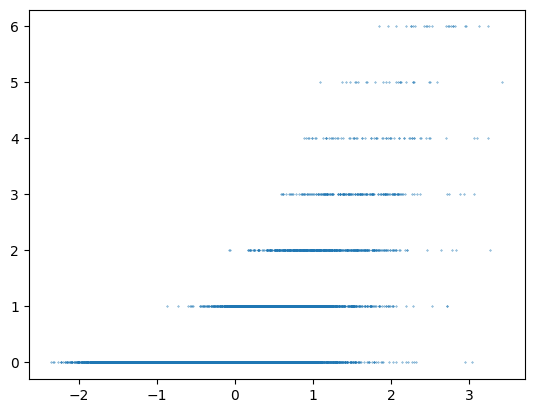

In [9]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['N_halos_all'][0,...].flatten()[::100], s=0.1)


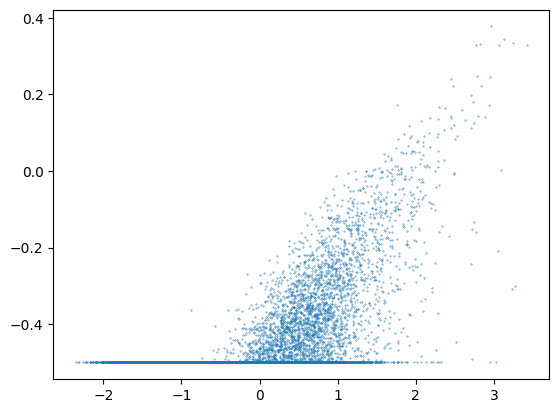

In [10]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['M1_halos_all_norm'][0,...].flatten()[::100], s=0.1)



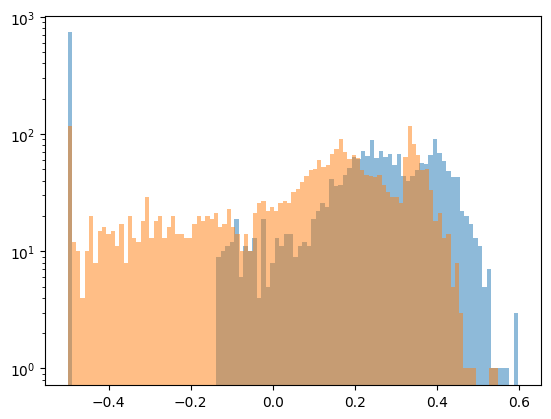

In [11]:
# lgMmin
# return_dict_train_FP['M1_halos_all_norm']
delta_all = return_dict_train['df_d_all_nsh'][0,:,0,...].reshape(512, 4096)
indsel = np.where(delta_all > 2.5)
pl.figure()
_ = pl.hist(return_dict_train_FP['M1_halos_all_norm'][0,...][indsel].flatten(), bins=100, alpha=0.5, label='FP')
_ = pl.hist(return_dict_train['M1_halos_all_norm'][0,...][indsel].flatten(), bins=100, alpha=0.5, label='PM')
pl.yscale('log')


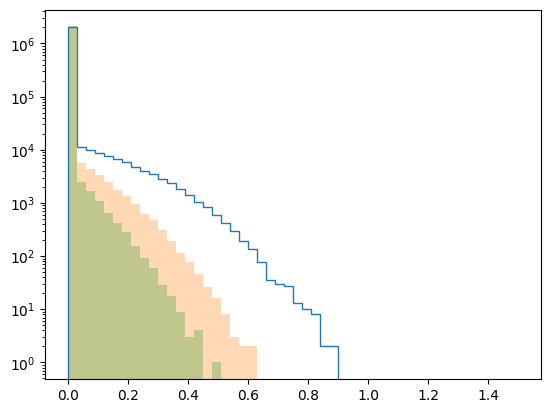

In [14]:
pl.figure()
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,0].flatten(), bins=50, range=(0,1.5), histtype='step', label='z=0')
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,1].flatten(), bins=50, range=(0,1.5), alpha=0.3)
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,2].flatten(), bins=50, range=(0,1.5), alpha=0.3)
pl.yscale('log')


In [15]:
return_dict_train['df_d_all'].shape

(1, 512, 4, 32, 32, 32)

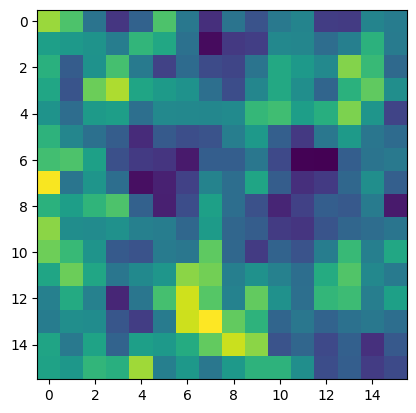

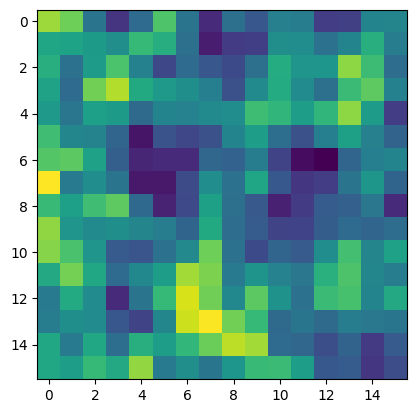

In [16]:
indp = 109

pl.figure()
pl.imshow(return_dict_train['df_d_all_nsh'][0,indp, 0, 8, :, :])
pl.figure()
pl.imshow(return_dict_train_FP['df_d_all_nsh'][0,indp, 0, 8, :, :])



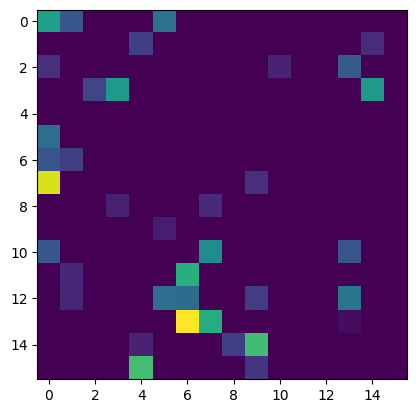

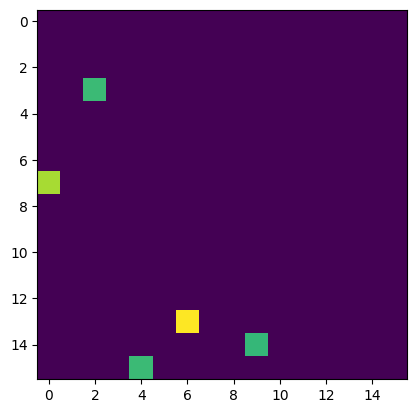

In [17]:
# indp = 10
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.figure()
pl.imshow(return_dict_train['M_halos_all_sort_norm'][0,indp,:, 0].reshape(16,16,16)[8,:,:])
pl.figure()
pl.imshow(return_dict_train_FP['M_halos_all_sort_norm'][0,indp,:,0].reshape(16,16,16)[8,:,:])



In [12]:
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


# num_cond_Ntot = num_cond
# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()


In [13]:
# base_dist_Ntot


In [14]:
from torch.utils.data import DataLoader, Dataset
# class LoadCustomData(Dataset):
#     def __init__(self, return_dict, return_dict_FP, all_gpu=False):
#         if return_dict_FP is not None:
#             self.cond_tensor = torch.Tensor(np.array(return_dict_FP['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict_FP['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
#         else:
#             self.cond_tensor = torch.Tensor(np.array(return_dict['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

#         self.mask_tensor_M1_train = torch.Tensor(np.array(return_dict['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#         self.mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

#         self.X_M1 = torch.Tensor((np.array(return_dict['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Nhalo = torch.Tensor(np.array(return_dict['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Mdiff = torch.Tensor(np.array(return_dict['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
#         self.Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

#         if return_dict_FP is not None:
#             self.mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#             self.X_M1_FP = torch.Tensor((np.array(return_dict_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         else:
#             self.mask_tensor_M1_train_FP = None
#             self.X_M1_FP = None
#         if all_gpu:
            # self.cond_tensor = self.cond_tensor.cuda(dev)
            # self.cond_tensor_nsh = self.cond_tensor_nsh.cuda(dev)
            # self.mask_tensor_M1_train = self.mask_tensor_M1_train.cuda(dev)
            # self.mask_tensor_Mdiff_train = self.mask_tensor_Mdiff_train.cuda(dev)
            # self.X_M1 = self.X_M1.cuda(dev)
            # self.X_Nhalo = self.X_Nhalo.cuda(dev)
            # self.X_Mdiff = self.X_Mdiff.cuda(dev)
            # self.Nhalos_truth_tensor = self.Nhalos_truth_tensor.cuda(dev)
            # if return_dict_FP is not None:
            #     self.mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP.cuda(dev)
            #     self.X_M1_FP = self.X_M1_FP.cuda(dev)

#     def __len__(self):
#         return len(self.cond_tensor)

#     def __getitem__(self, idx):
#         cond_tensor = (self.cond_tensor[idx,...])
#         cond_tensor_nsh = self.cond_tensor_nsh[idx,...]
#         mask_tensor_M1_train = self.mask_tensor_M1_train[idx,...]
#         mask_tensor_Mdiff_train =self.mask_tensor_Mdiff_train[idx,...]
#         X_M1 = self.X_M1[idx,...]
#         X_Nhalo = self.X_Nhalo[idx,...]
#         X_Mdiff = self.X_Mdiff[idx,...]
#         Nhalos_truth_tensor = self.Nhalos_truth_tensor[idx,...]
#         if self.mask_tensor_M1_train_FP is not None:
#             mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP[idx,...]
#             X_M1_FP = self.X_M1_FP[idx,...]
#         else:
#             mask_tensor_M1_train_FP = torch.Tensor([-9999])
#             X_M1_FP = torch.Tensor([-9999])

#         return (cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, X_Nhalo,
#                  X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP)


from torch.utils.data import DataLoader, Dataset


ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_train_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
    X_M1_FP = torch.Tensor((np.array(return_dict_train_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
else:
    mask_tensor_M1_train_FP = None
    X_M1_FP = None

    
cond_tensor = cond_tensor.cuda(dev)
cond_tensor_nsh = cond_tensor_nsh.cuda(dev)
mask_tensor_M1_train = mask_tensor_M1_train.cuda(dev)
mask_tensor_Mdiff_train = mask_tensor_Mdiff_train.cuda(dev)
X_M1 = X_M1.cuda(dev)
X_Nhalo = X_Nhalo.cuda(dev)
X_Mdiff = X_Mdiff.cuda(dev)


Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = mask_tensor_M1_train_FP.cuda(dev)
    X_M1_FP = X_M1_FP.cuda(dev)



In [15]:
torch.amin(Nhalos_truth_tensor), torch.amax(Nhalos_truth_tensor), return_dict_train['mu_all']


(tensor(0., device='cuda:0'),
 tensor(6., device='cuda:0'),
 array([1, 2, 3, 4, 5, 6, 7]))

In [12]:
# # X_Nhalo.shape, cond_tensor_nsh.shape
# np.array(return_dict_train['N_halos_all']).shape, cond_nsh.shape, np.array(return_dict_train['M1_halos_all_norm']).shape

# Nhalos_3d = np.array(return_dict_train['N_halos_all']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# Mhalos_3d = np.array(return_dict_train['M1_halos_all_norm']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# delta_m_3d = cond_nsh[...,0]




In [13]:
# # make a three panel plot
# import matplotlib.pyplot as pl
# import matplotlib
# %matplotlib inline
# indsim = 300
# pl.figure()
# pl.subplot(131)
# pl.imshow(Nhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(132)
# pl.imshow(Mhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(133)
# pl.imshow(delta_m_3d[0,indsim,0,...])
# # pl.colorbar()


In [14]:

# delta_m = cond_tensor_nsh[0,:,0].cpu().numpy()
# Nhalo = X_Nhalo[0,:,0].cpu().numpy()
# indsel = np.where((delta_m > 3) & (delta_m < 100))[0]
# pl.figure()
# pl.scatter(delta_m[indsel], Nhalo[indsel], s=0.1)


In [15]:
# np.amin(delta_m), np.amax(delta_m), np.amin(Nhalo), np.amax(Nhalo)



In [16]:
with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/CLIPPED_FINALTEST_SUBSEL_Ntot_M1_Mdiff_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist) + '_TRY2'

save_string = config_train['save_string']

save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/LONGTRAIN_CLIPPED_FINALTEST_SUBSEL_Ntot_M1_Mdiff_plexp_ns_' + str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim  \
                            + '_nc' + str(nc) + '_mass_' + mass_type + \
                            '_KM1_' + str(K_M1) + \
                            '_stype_' + stype + \
                            '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist) + '_Nmax' + str(Nmax) + save_string


print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# make directory if it doesn't exist
import os
if not os.path.exists(save_bestfit_model_dir):
    os.makedirs(save_bestfit_model_dir)


nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']



# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_TEST_FINALS_SIMPLE_BATCHED_model_save_nsim' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim + \
#                             '_nsd' + str(ns_d) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train) + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_SUBSEL_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_NOSUBSEL_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# # make directory if it doesn't exist
# import os
# if not os.path.exists(save_bestfit_model_dir):
#     os.makedirs(save_bestfit_model_dir)

# start_with_bestfit = config_train['start_with_bestfit']

# if start_with_bestfit:
#     try:
#         print('loading bestfit model')
#         bestfit_model = (torch.load(save_bestfit_model_name))
#         model.load_state_dict(bestfit_model['state_dict'])
#         optimizer.load_state_dict(bestfit_model['optimizer'])
#         scheduler.load_state_dict(bestfit_model['scheduler'])
#         loss_min = bestfit_model['loss_min']
#         loss = bestfit_model['loss']
#         lr = bestfit_model['lr']
#         epoch_tot_counter = bestfit_model['epoch_tot_counter']
#         for g in optimizer.param_groups:
#             # g['lr'] = lr
#             g['lr'] = 0.01          

#     except:
#         print('no bestfit model found, running new')
#         pass
#         epoch_tot_counter = 0


# dataset = LoadCustomData(return_dict_train, return_dict_train_FP, all_gpu=all_gpu)
# dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=1 - all_gpu, num_workers=1)




/mnt/home/spandey/ceph/AR_NPE/TRAIN_ROCKSTAR_FOF/LONGTRAIN_CLIPPED_FINALTEST_SUBSEL_Ntot_M1_Mdiff_plexp_ns_10_cond_sim_fastpm_nc4_mass_rockstar_200c_KM1_8_stype_cic_L2normNtothist_False_L2normM1hist_False_Nmax6_COND_FPMFOF False


In [11]:
num_cond_Ntot = num_cond

model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=base_dist_Ntot   
    )

num_cond_M1 = num_cond + 1
# if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
if cond_sim == 'fastpm':
    num_cond_M1 += 2

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf    
    )

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )

ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Ntot = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    )

model.to(dev)
print()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_all_it = []
loss_min = 1e20
epoch_tot_counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=100, verbose=True, cooldown=100, min_lr=1e-8)





In [12]:
jf = 1
save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)

print('loading bestfit model')
bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])
scheduler.load_state_dict(bestfit_model['scheduler'])
loss_min = bestfit_model['loss_min']
loss = bestfit_model['loss']
lr = bestfit_model['lr']
epoch_tot_counter = bestfit_model['epoch_tot_counter']
for g in optimizer.param_groups:
    g['lr'] = lr
    # g['lr'] = 0.001/4.

print(loss_min, epoch_tot_counter, lr)






loading bestfit model
-1.499788761138916 8881 0.00025


In [17]:
# print(loss)

# nepochs_Ntot_only = 1000
# L2norm_Ntothist = True
# print(nflows_train, nepochs_Ntot_only, nepochs_Ntot_M1_only, L2norm_Ntothist, L2norm_M1hist)
nepochs_Ntot_only, nepochs_Ntot_M1_only, nepochs_all


(20000, 10000, 28000)

In [ ]:
nepochs_array = [nepochs_Ntot_only, nepochs_Ntot_M1_only, nepochs_all]
train_Ntot_array = [1, 1, 1]
train_M1_array = [0, 1, 1]
train_Mdiff_array = [0, 0, 1]

# for jf in range(nflows_train):
for jf in range(1,10):
# for jf in np.arange(7,16):   
# for jf in np.arange(0,7):
    try:
        print('doing flow ', jf)
        epoch_tot_counter = 0
        num_cond_Ntot = num_cond
        
        model_Ntot = SumGaussModel(
            hidden_dim=hidden_dim_MAF,
            num_cond=num_cond_Ntot,
            ngauss=return_dict_train['ngauss_Nhalo'],
            mu_all=return_dict_train['mu_all'],
            sig_all=return_dict_train['sig_all'],
            base_dist=base_dist_Ntot   
            )

        num_cond_M1 = num_cond + 1
        # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
        if cond_sim == 'fastpm':
            num_cond_M1 += 2

        model_M1 = NSF_M1_CNNcond(
            K=K_M1,
            B=B_M1,
            hidden_dim=hidden_dim_MAF,
            num_cond=num_cond_M1,
            nflows=nflows_M1_NSF,
            base_dist=base_dist_M1,
            ngauss=ngauss_M1,
            lgM_rs_tointerp=lgM_rescaled,
            hmf_pdf_tointerp=hmf_pdf,
            hmf_cdf_tointerp=hmf_cdf    
            )

        ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
        num_cond_Mdiff = num_cond + 2
        model_Mdiff = NSF_Mdiff_CNNcond(
            dim=ndim_diff,
            K=K_Mdiff,
            B=B_Mdiff,
            hidden_dim=hidden_dim_MAF,
            num_cond=num_cond_Mdiff,
            nflows=nflows_Mdiff_NSF,
            base_dist=base_dist_Mdiff,
            mu_pos=True
            )

        ndim = ndim_diff + 1
        model = COMBINED_Model(
            None,
            model_Mdiff,
            # None,
            model_M1,
            model_Ntot,
            ndim,
            ksize,
            ns_d,
            ns_h,
            nb,
            ninp,
            nfeature_cnn,
            nout_cnn,
            layers_types=layers_types,
            act='tanh',
            padding='valid',
            sep_Ntot_cond=True,
            sep_M1_cond=True,
            sep_Mdiff_cond=True,
            num_cond_Ntot = num_cond_Ntot,
            num_cond_M1 = num_cond_M1,
            num_cond_Mdiff = num_cond_Mdiff
            )

        model.to(dev)

        print()

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_all_it = []
        loss_min = 1e20
        epoch_tot_counter = 0
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=100, verbose=True, cooldown=100, min_lr=1e-8)



        save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
        for jn in (range(len(nepochs_array))):
            loss_min = 1e20
            torch.cuda.empty_cache()
            ninit = 0
            nepochs = nepochs_array[jn]
            if nepochs > 0:
                train_Ntot = train_Ntot_array[jn]
                train_M1 = train_M1_array[jn]
                train_Mdiff = train_Mdiff_array[jn]

                # if jn > 0:
                #     print('loading bestfit model')
                #     bestfit_model = (torch.load(save_bestfit_model_name))
                #     model.load_state_dict(bestfit_model['state_dict'])
                #     optimizer.load_state_dict(bestfit_model['optimizer'])
                #     scheduler.load_state_dict(bestfit_model['scheduler'])
                #     # loss_min = bestfit_model['loss_min']
                #     loss = bestfit_model['loss']
                #     lr = bestfit_model['lr']
                for g in optimizer.param_groups:
                    g['lr'] = learning_rate

                for jt in tqdm(range(nepochs)):
                    # for jd in range(len(dataloader)):
                    torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
                        X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                                X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

                    if cond_sim == 'quijote':               
                        mask_tensor_M1_train_FP_jd = None
                        X_M1_FP_jd = None
                    
                    torch.cuda.empty_cache()
                    # if 1-all_gpu:
                    # cond_tensor_jd = cond_tensor_jd.cuda(dev)
                    # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
                    # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
                    # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
                    # X_M1_jd = X_M1_jd.cuda(dev)
                    # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
                    # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
                    # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
                    # if mask_tensor_M1_train_FP_jd is not None:
                    #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
                    #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
                    # torch.cuda.empty_cache()
                                    
                    loss = model(
                        X_Mdiff_jd,
                        X_M1_jd,
                        X_Nhalo_jd,
                        cond_x=cond_tensor_jd,
                        cond_x_nsh=cond_tensor_nsh_jd,
                        mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
                        mask_M1_truth_all=mask_tensor_M1_train_jd,
                        Nhalos_truth_all=Nhalos_truth_tensor_jd,
                        use_Ntot_samples=False,
                        use_M1_samples=False,
                        train_Ntot=train_Ntot,
                        train_M1=train_M1,
                        train_Mdiff=train_Mdiff,
                        # x_Mdiff_FP=X_Mdiff_FP,
                        x_M1_FP=X_M1_FP_jd,
                        # x_Ntot_FP=X_Nhalo_FP,
                        # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
                        # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
                        mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
                        L2norm_Ntothist=L2norm_Ntothist,
                        L2norm_M1hist=L2norm_M1hist        
                        )

                    loss.backward()
                    optimizer.step()
                    scheduler.step(loss)
                    epoch_tot_counter += 1
                    if (np.mod(jt, int(nepochs / 200)) == 0) or (jt == nepochs - 1):
                        if float(loss.cpu().detach().numpy()) < loss_min:
                            loss_min = float(loss.cpu().detach().numpy())
                            print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                                'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                                'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
                            lr=optimizer.param_groups[0]['lr']
                            # print(loss_min, lr)
                            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                                    'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

                            torch.save(
                                state, save_bestfit_model_name
                                )
    except Exception as e:
        print(e)
        print('error in flow:', jf)
        pass




doing flow  0



  0%|          | 1/20000 [00:01<8:20:36,  1.50s/it]

saving bf at: , with loss: -0.9671 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


  1%|          | 102/20000 [00:12<46:20,  7.16it/s] 

saving bf at: , with loss: -1.162 , at epoch: 100 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 101


  1%|          | 201/20000 [00:22<34:27,  9.58it/s]  

saving bf at: , with loss: -1.21243 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 201


  2%|▏         | 301/20000 [00:32<32:28, 10.11it/s]

saving bf at: , with loss: -1.23821 , at epoch: 300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 301


  2%|▏         | 402/20000 [00:43<34:07,  9.57it/s]  

saving bf at: , with loss: -1.25433 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 401


  3%|▎         | 502/20000 [00:53<33:03,  9.83it/s]

saving bf at: , with loss: -1.26242 , at epoch: 500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 501


  3%|▎         | 601/20000 [01:03<33:14,  9.73it/s]

saving bf at: , with loss: -1.2678 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


  4%|▎         | 701/20000 [01:14<33:22,  9.64it/s]  

saving bf at: , with loss: -1.27136 , at epoch: 700 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 701


  4%|▍         | 802/20000 [01:24<32:22,  9.88it/s]

saving bf at: , with loss: -1.27425 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 801


  5%|▍         | 902/20000 [01:34<32:01,  9.94it/s]

saving bf at: , with loss: -1.2764 , at epoch: 900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 901


  5%|▌         | 1002/20000 [01:45<32:09,  9.84it/s] 

saving bf at: , with loss: -1.27792 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


  6%|▌         | 1101/20000 [01:55<32:10,  9.79it/s]

saving bf at: , with loss: -1.27893 , at epoch: 1100 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1101


  6%|▌         | 1202/20000 [02:05<31:55,  9.81it/s]

saving bf at: , with loss: -1.28098 , at epoch: 1200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1201


  7%|▋         | 1301/20000 [02:16<33:05,  9.42it/s]

saving bf at: , with loss: -1.28135 , at epoch: 1300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1301


  7%|▋         | 1402/20000 [02:26<31:42,  9.78it/s]

saving bf at: , with loss: -1.28314 , at epoch: 1400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1401


  8%|▊         | 1502/20000 [02:36<31:46,  9.70it/s]

saving bf at: , with loss: -1.28403 , at epoch: 1500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1501


  9%|▊         | 1702/20000 [02:57<31:16,  9.75it/s]  

saving bf at: , with loss: -1.28505 , at epoch: 1700 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1701


  9%|▉         | 1801/20000 [03:07<31:24,  9.66it/s]

saving bf at: , with loss: -1.28594 , at epoch: 1800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1801


 10%|▉         | 1902/20000 [03:18<30:34,  9.87it/s]  

saving bf at: , with loss: -1.28632 , at epoch: 1900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1901


 10%|█         | 2002/20000 [03:28<30:27,  9.85it/s]

saving bf at: , with loss: -1.28677 , at epoch: 2000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2001


 11%|█         | 2202/20000 [03:49<29:54,  9.92it/s]  

saving bf at: , with loss: -1.28757 , at epoch: 2200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2201


 12%|█▏        | 2302/20000 [03:59<29:41,  9.93it/s]

saving bf at: , with loss: -1.28812 , at epoch: 2300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2301


 12%|█▏        | 2401/20000 [04:09<30:09,  9.73it/s]

saving bf at: , with loss: -1.28857 , at epoch: 2400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2401


 13%|█▎        | 2602/20000 [04:30<29:17,  9.90it/s]  

saving bf at: , with loss: -1.28951 , at epoch: 2600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2601


 14%|█▎        | 2701/20000 [04:39<35:30,  8.12it/s]

saving bf at: , with loss: -1.28985 , at epoch: 2700 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2701


 14%|█▍        | 2802/20000 [04:50<28:34, 10.03it/s]  

saving bf at: , with loss: -1.29019 , at epoch: 2800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2801


 15%|█▍        | 2902/20000 [05:00<29:50,  9.55it/s]

saving bf at: , with loss: -1.29026 , at epoch: 2900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2901


 15%|█▌        | 3002/20000 [05:12<45:09,  6.27it/s]  

saving bf at: , with loss: -1.29069 , at epoch: 3000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3001


 16%|█▌        | 3102/20000 [05:22<30:06,  9.35it/s]

saving bf at: , with loss: -1.29088 , at epoch: 3100 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3101


 16%|█▌        | 3201/20000 [05:33<30:28,  9.19it/s]

saving bf at: , with loss: -1.2911 , at epoch: 3200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3201


 18%|█▊        | 3502/20000 [06:05<29:28,  9.33it/s]  

saving bf at: , with loss: -1.29165 , at epoch: 3500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3501


 18%|█▊        | 3602/20000 [06:16<28:53,  9.46it/s]  

saving bf at: , with loss: -1.29167 , at epoch: 3600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3601


 19%|█▊        | 3702/20000 [06:27<28:41,  9.47it/s]

saving bf at: , with loss: -1.29195 , at epoch: 3700 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3701


 19%|█▉        | 3802/20000 [06:37<28:31,  9.46it/s]

saving bf at: , with loss: -1.29203 , at epoch: 3800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3801


 20%|█▉        | 3902/20000 [06:49<28:27,  9.43it/s]  

saving bf at: , with loss: -1.29217 , at epoch: 3900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3901


 21%|██        | 4102/20000 [07:09<36:28,  7.26it/s]

saving bf at: , with loss: -1.29241 , at epoch: 4100 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4101


 21%|██        | 4202/20000 [07:21<28:35,  9.21it/s]  

saving bf at: , with loss: -1.29256 , at epoch: 4200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4201


 22%|██▏       | 4402/20000 [07:43<28:04,  9.26it/s]  

saving bf at: , with loss: -1.29263 , at epoch: 4400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4401


 23%|██▎       | 4502/20000 [07:53<28:14,  9.15it/s]

saving bf at: , with loss: -1.29285 , at epoch: 4500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4501


 23%|██▎       | 4602/20000 [08:04<27:03,  9.49it/s]

saving bf at: , with loss: -1.29293 , at epoch: 4600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4601


 24%|██▍       | 4801/20000 [08:26<27:49,  9.10it/s]  

saving bf at: , with loss: -1.29308 , at epoch: 4800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4801


 25%|██▍       | 4902/20000 [08:36<26:50,  9.38it/s]

saving bf at: , with loss: -1.29318 , at epoch: 4900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4901


 25%|██▌       | 5002/20000 [08:48<26:24,  9.47it/s]  

saving bf at: , with loss: -1.29318 , at epoch: 5000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5001


 26%|██▌       | 5202/20000 [09:08<26:54,  9.17it/s]

saving bf at: , with loss: -1.29346 , at epoch: 5200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5201


 27%|██▋       | 5402/20000 [09:30<25:48,  9.42it/s]  

saving bf at: , with loss: -1.2935 , at epoch: 5400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5401


 28%|██▊       | 5501/20000 [09:41<57:21,  4.21it/s]

saving bf at: , with loss: -1.29353 , at epoch: 5500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5501


 28%|██▊       | 5601/20000 [09:52<25:32,  9.40it/s]  

saving bf at: , with loss: -1.29374 , at epoch: 5600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5601


 29%|██▉       | 5801/20000 [10:14<25:46,  9.18it/s]  

saving bf at: , with loss: -1.29379 , at epoch: 5800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5801


 30%|██▉       | 5901/20000 [10:24<25:50,  9.09it/s]

saving bf at: , with loss: -1.29393 , at epoch: 5900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5901


 31%|███       | 6201/20000 [10:56<24:34,  9.36it/s]  

saving bf at: , with loss: -1.29409 , at epoch: 6200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6201


 32%|███▏      | 6302/20000 [11:07<24:03,  9.49it/s]

saving bf at: , with loss: -1.29412 , at epoch: 6300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6301


 33%|███▎      | 6502/20000 [11:28<24:20,  9.24it/s]  

saving bf at: , with loss: -1.29417 , at epoch: 6500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6501


 33%|███▎      | 6601/20000 [11:39<24:25,  9.14it/s]

saving bf at: , with loss: -1.29426 , at epoch: 6600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6601


 36%|███▌      | 7102/20000 [12:33<23:16,  9.24it/s]  

saving bf at: , with loss: -1.29437 , at epoch: 7100 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7101


 36%|███▌      | 7202/20000 [12:44<23:07,  9.23it/s]  

saving bf at: , with loss: -1.29454 , at epoch: 7200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7201


 37%|███▋      | 7302/20000 [12:55<22:08,  9.56it/s]

saving bf at: , with loss: -1.2946 , at epoch: 7300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7301


 37%|███▋      | 7402/20000 [13:05<22:22,  9.38it/s]

saving bf at: , with loss: -1.29465 , at epoch: 7400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7401


 38%|███▊      | 7502/20000 [13:16<22:02,  9.45it/s]

saving bf at: , with loss: -1.29466 , at epoch: 7500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7501


 38%|███▊      | 7602/20000 [13:27<22:08,  9.33it/s]

saving bf at: , with loss: -1.2947 , at epoch: 7600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7601


 40%|███▉      | 7902/20000 [13:59<21:53,  9.21it/s]

saving bf at: , with loss: -1.29478 , at epoch: 7900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7901


 40%|████      | 8002/20000 [14:09<27:33,  7.26it/s]

saving bf at: , with loss: -1.29481 , at epoch: 8000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8001


 41%|████      | 8201/20000 [14:31<21:24,  9.19it/s]

saving bf at: , with loss: -1.29488 , at epoch: 8200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8201


 42%|████▏     | 8401/20000 [14:52<21:43,  8.90it/s]

saving bf at: , with loss: -1.29489 , at epoch: 8400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8401


 43%|████▎     | 8502/20000 [15:03<20:40,  9.27it/s]

saving bf at: , with loss: -1.29501 , at epoch: 8500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8501


 43%|████▎     | 8602/20000 [15:14<20:07,  9.44it/s]

saving bf at: , with loss: -1.29506 , at epoch: 8600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8601


 44%|████▎     | 8702/20000 [15:25<20:20,  9.26it/s]

saving bf at: , with loss: -1.29507 , at epoch: 8700 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8701


 45%|████▍     | 8902/20000 [15:47<19:42,  9.39it/s]

saving bf at: , with loss: -1.2951 , at epoch: 8900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8901


 45%|████▌     | 9002/20000 [15:57<19:45,  9.28it/s]

saving bf at: , with loss: -1.29513 , at epoch: 9000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 9001


 47%|████▋     | 9301/20000 [16:29<19:43,  9.04it/s]

saving bf at: , with loss: -1.29528 , at epoch: 9300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 9301


 49%|████▊     | 9702/20000 [17:12<20:20,  8.44it/s]

saving bf at: , with loss: -1.29538 , at epoch: 9700 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 9701


 52%|█████▏    | 10302/20000 [18:16<17:12,  9.39it/s]

saving bf at: , with loss: -1.29555 , at epoch: 10300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 10301


 53%|█████▎    | 10502/20000 [18:37<16:59,  9.32it/s]

saving bf at: , with loss: -1.29561 , at epoch: 10500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 10501


 55%|█████▍    | 10902/20000 [19:20<16:19,  9.29it/s]

saving bf at: , with loss: -1.29566 , at epoch: 10900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 10901


 56%|█████▌    | 11202/20000 [19:52<15:33,  9.42it/s]

saving bf at: , with loss: -1.29574 , at epoch: 11200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 11201


 57%|█████▋    | 11401/20000 [20:14<15:13,  9.41it/s]

saving bf at: , with loss: -1.2958 , at epoch: 11400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 11401


 58%|█████▊    | 11502/20000 [20:25<15:14,  9.29it/s]

saving bf at: , with loss: -1.29582 , at epoch: 11500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 11501


 59%|█████▊    | 11701/20000 [20:46<15:12,  9.10it/s]

saving bf at: , with loss: -1.29587 , at epoch: 11700 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 11701


 59%|█████▉    | 11802/20000 [20:57<14:35,  9.36it/s]

saving bf at: , with loss: -1.29591 , at epoch: 11800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 11801


 60%|██████    | 12002/20000 [21:18<14:10,  9.40it/s]

saving bf at: , with loss: -1.29595 , at epoch: 12000 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 12001


 61%|██████    | 12102/20000 [21:29<14:17,  9.21it/s]

saving bf at: , with loss: -1.29597 , at epoch: 12100 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 12101


 61%|██████    | 12219/20000 [21:42<21:19,  6.08it/s]

Epoch 12218: reducing learning rate of group 0 to 2.5000e-04.


 62%|██████▏   | 12420/20000 [22:02<13:07,  9.62it/s]

Epoch 12419: reducing learning rate of group 0 to 6.2500e-05.


 63%|██████▎   | 12621/20000 [22:24<12:32,  9.80it/s]

Epoch 12620: reducing learning rate of group 0 to 1.5625e-05.


 64%|██████▍   | 12822/20000 [22:46<12:24,  9.65it/s]

Epoch 12821: reducing learning rate of group 0 to 3.9063e-06.


 65%|██████▌   | 13023/20000 [23:06<12:07,  9.60it/s]

Epoch 13022: reducing learning rate of group 0 to 9.7656e-07.


 66%|██████▌   | 13224/20000 [23:28<11:39,  9.69it/s]

Epoch 13223: reducing learning rate of group 0 to 2.4414e-07.


 67%|██████▋   | 13426/20000 [23:50<11:13,  9.77it/s]

Epoch 13424: reducing learning rate of group 0 to 6.1035e-08.


 68%|██████▊   | 13626/20000 [24:12<22:29,  4.72it/s]

Epoch 13625: reducing learning rate of group 0 to 1.5259e-08.


  0%|          | 1/10000 [00:00<2:43:08,  1.02it/s]

saving bf at: , with loss: -1.36196 , at epoch: 0 learning rate: 1.52587890625e-08 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20001


  1%|          | 51/10000 [00:35<1:46:49,  1.55it/s]

saving bf at: , with loss: -1.36197 , at epoch: 50 learning rate: 1.52587890625e-08 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20051


  1%|          | 101/10000 [01:12<2:22:13,  1.16it/s]

saving bf at: , with loss: -1.36197 , at epoch: 100 learning rate: 1.52587890625e-08 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20101


  2%|▏         | 151/10000 [01:48<2:01:09,  1.35it/s]

saving bf at: , with loss: -1.36197 , at epoch: 150 learning rate: 1.52587890625e-08 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20151


  2%|▏         | 201/10000 [02:24<1:41:19,  1.61it/s]

saving bf at: , with loss: -1.36197 , at epoch: 200 learning rate: 1.52587890625e-08 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20201


  2%|▏         | 241/10000 [02:54<1:57:43,  1.38it/s]


KeyboardInterrupt: 

In [19]:
train_Ntot = 1
train_M1 = 1
train_Mdiff = 0
nepochs = 8000
# if jn > 0:
#     print('loading bestfit model')
#     bestfit_model = (torch.load(save_bestfit_model_name))
#     model.load_state_dict(bestfit_model['state_dict'])
#     optimizer.load_state_dict(bestfit_model['optimizer'])
#     scheduler.load_state_dict(bestfit_model['scheduler'])
#     # loss_min = bestfit_model['loss_min']
#     loss = bestfit_model['loss']
#     lr = bestfit_model['lr']
for g in optimizer.param_groups:
    g['lr'] = learning_rate

for jt in tqdm(range(nepochs)):
    # for jd in range(len(dataloader)):
    torch.cuda.empty_cache()
    optimizer.zero_grad()
    cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
        X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

    if cond_sim == 'quijote':               
        mask_tensor_M1_train_FP_jd = None
        X_M1_FP_jd = None
    
    torch.cuda.empty_cache()
    # if 1-all_gpu:
    # cond_tensor_jd = cond_tensor_jd.cuda(dev)
    # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
    # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
    # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
    # X_M1_jd = X_M1_jd.cuda(dev)
    # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
    # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
    # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
    # if mask_tensor_M1_train_FP_jd is not None:
    #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
    #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
    # torch.cuda.empty_cache()
                    
    loss = model(
        X_Mdiff_jd,
        X_M1_jd,
        X_Nhalo_jd,
        cond_x=cond_tensor_jd,
        cond_x_nsh=cond_tensor_nsh_jd,
        mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
        mask_M1_truth_all=mask_tensor_M1_train_jd,
        Nhalos_truth_all=Nhalos_truth_tensor_jd,
        use_Ntot_samples=False,
        use_M1_samples=False,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff,
        # x_Mdiff_FP=X_Mdiff_FP,
        x_M1_FP=X_M1_FP_jd,
        # x_Ntot_FP=X_Nhalo_FP,
        # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
        # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
        mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
        L2norm_Ntothist=L2norm_Ntothist,
        L2norm_M1hist=L2norm_M1hist        
        )

    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    epoch_tot_counter += 1
    if (np.mod(jt, int(nepochs / 200)) == 0) or (jt == nepochs - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
            lr=optimizer.param_groups[0]['lr']
            # print(loss_min, lr)
            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

            torch.save(
                state, save_bestfit_model_name
                )




  0%|          | 1/8000 [00:00<44:54,  2.97it/s]

saving bf at: , with loss: -1.36197 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20242


  1%|          | 41/8000 [00:29<1:38:46,  1.34it/s]

saving bf at: , with loss: -1.36724 , at epoch: 40 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20282


  1%|          | 81/8000 [00:58<1:40:05,  1.32it/s]

saving bf at: , with loss: -1.3927 , at epoch: 80 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20322


  2%|▏         | 121/8000 [01:26<1:16:36,  1.71it/s]

saving bf at: , with loss: -1.41221 , at epoch: 120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20362


  2%|▏         | 161/8000 [01:56<1:29:47,  1.46it/s]

saving bf at: , with loss: -1.42257 , at epoch: 160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20402


  3%|▎         | 201/8000 [02:26<1:56:34,  1.12it/s]

saving bf at: , with loss: -1.42782 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20442


  3%|▎         | 241/8000 [02:55<2:09:28,  1.00s/it]

saving bf at: , with loss: -1.43035 , at epoch: 240 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20482


  4%|▎         | 281/8000 [03:24<1:37:09,  1.32it/s]

saving bf at: , with loss: -1.4342 , at epoch: 280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20522


  5%|▍         | 361/8000 [04:22<1:39:35,  1.28it/s]

saving bf at: , with loss: -1.43839 , at epoch: 360 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20602


  5%|▌         | 401/8000 [04:51<1:18:25,  1.61it/s]

saving bf at: , with loss: -1.44061 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20642


  6%|▌         | 441/8000 [05:20<1:18:07,  1.61it/s]

saving bf at: , with loss: -1.44232 , at epoch: 440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20682


  6%|▌         | 481/8000 [05:50<1:17:55,  1.61it/s]

saving bf at: , with loss: -1.44292 , at epoch: 480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20722


  7%|▋         | 521/8000 [06:19<1:17:36,  1.61it/s]

saving bf at: , with loss: -1.44421 , at epoch: 520 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20762


  7%|▋         | 561/8000 [06:48<1:16:50,  1.61it/s]

saving bf at: , with loss: -1.44526 , at epoch: 560 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20802


  8%|▊         | 641/8000 [07:47<1:33:51,  1.31it/s]

saving bf at: , with loss: -1.44669 , at epoch: 640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20882


  9%|▊         | 681/8000 [08:16<1:34:53,  1.29it/s]

saving bf at: , with loss: -1.4473 , at epoch: 680 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20922


  9%|▉         | 721/8000 [08:45<1:31:50,  1.32it/s]

saving bf at: , with loss: -1.44781 , at epoch: 720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 20962


 10%|▉         | 761/8000 [09:15<1:40:07,  1.21it/s]

saving bf at: , with loss: -1.44838 , at epoch: 760 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21002


 10%|█         | 801/8000 [09:44<1:29:22,  1.34it/s]

saving bf at: , with loss: -1.44863 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21042


 11%|█         | 841/8000 [10:13<1:29:15,  1.34it/s]

saving bf at: , with loss: -1.44921 , at epoch: 840 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21082


 11%|█         | 881/8000 [10:42<1:30:11,  1.32it/s]

saving bf at: , with loss: -1.44936 , at epoch: 880 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21122


 12%|█▏        | 921/8000 [11:12<1:30:21,  1.31it/s]

saving bf at: , with loss: -1.44941 , at epoch: 920 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21162


 12%|█▏        | 961/8000 [11:41<1:13:13,  1.60it/s]

saving bf at: , with loss: -1.45005 , at epoch: 960 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21202


 13%|█▎        | 1001/8000 [12:11<1:27:58,  1.33it/s]

saving bf at: , with loss: -1.45044 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21242


 13%|█▎        | 1041/8000 [12:40<1:12:40,  1.60it/s]

saving bf at: , with loss: -1.45075 , at epoch: 1040 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21282


 14%|█▎        | 1081/8000 [13:09<1:29:52,  1.28it/s]

saving bf at: , with loss: -1.4512 , at epoch: 1080 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21322


 14%|█▍        | 1121/8000 [13:39<1:29:14,  1.28it/s]

saving bf at: , with loss: -1.45161 , at epoch: 1120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21362


 15%|█▍        | 1161/8000 [14:09<1:26:25,  1.32it/s]

saving bf at: , with loss: -1.45199 , at epoch: 1160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21402


 15%|█▌        | 1201/8000 [14:38<1:25:22,  1.33it/s]

saving bf at: , with loss: -1.45221 , at epoch: 1200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21442


 16%|█▌        | 1241/8000 [15:07<1:24:54,  1.33it/s]

saving bf at: , with loss: -1.45286 , at epoch: 1240 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21482


 16%|█▌        | 1281/8000 [15:37<1:24:34,  1.32it/s]

saving bf at: , with loss: -1.45319 , at epoch: 1280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21522


 17%|█▋        | 1321/8000 [16:06<1:26:33,  1.29it/s]

saving bf at: , with loss: -1.45323 , at epoch: 1320 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21562


 17%|█▋        | 1361/8000 [16:35<1:27:46,  1.26it/s]

saving bf at: , with loss: -1.45411 , at epoch: 1360 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21602


 18%|█▊        | 1441/8000 [17:34<1:08:07,  1.60it/s]

saving bf at: , with loss: -1.45492 , at epoch: 1440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21682


 19%|█▊        | 1481/8000 [18:03<1:23:15,  1.31it/s]

saving bf at: , with loss: -1.4553 , at epoch: 1480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21722


 19%|█▉        | 1521/8000 [18:33<1:24:21,  1.28it/s]

saving bf at: , with loss: -1.45569 , at epoch: 1520 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21762


 20%|█▉        | 1561/8000 [19:01<1:08:09,  1.57it/s]

saving bf at: , with loss: -1.456 , at epoch: 1560 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21802


 21%|██        | 1641/8000 [20:00<1:20:14,  1.32it/s]

saving bf at: , with loss: -1.45674 , at epoch: 1640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21882


 21%|██        | 1681/8000 [20:29<1:22:49,  1.27it/s]

saving bf at: , with loss: -1.45706 , at epoch: 1680 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 21922


 23%|██▎       | 1801/8000 [21:58<1:43:46,  1.00s/it]

saving bf at: , with loss: -1.45793 , at epoch: 1800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22042


 23%|██▎       | 1841/8000 [22:27<1:16:09,  1.35it/s]

saving bf at: , with loss: -1.45816 , at epoch: 1840 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22082


 24%|██▎       | 1881/8000 [22:56<1:25:23,  1.19it/s]

saving bf at: , with loss: -1.45842 , at epoch: 1880 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22122


 25%|██▍       | 1961/8000 [23:54<1:15:29,  1.33it/s]

saving bf at: , with loss: -1.45894 , at epoch: 1960 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22202


 25%|██▌       | 2001/8000 [24:23<1:02:10,  1.61it/s]

saving bf at: , with loss: -1.45906 , at epoch: 2000 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22242


 26%|██▌       | 2081/8000 [25:21<1:01:50,  1.60it/s]

saving bf at: , with loss: -1.45969 , at epoch: 2080 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22322


 27%|██▋       | 2121/8000 [25:51<1:14:42,  1.31it/s]

saving bf at: , with loss: -1.45994 , at epoch: 2120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22362


 28%|██▊       | 2201/8000 [26:50<1:12:11,  1.34it/s]

saving bf at: , with loss: -1.46032 , at epoch: 2200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22442


 29%|██▊       | 2281/8000 [27:48<59:17,  1.61it/s]  

saving bf at: , with loss: -1.46097 , at epoch: 2280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22522


 30%|██▉       | 2361/8000 [28:46<1:07:29,  1.39it/s]

saving bf at: , with loss: -1.4613 , at epoch: 2360 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22602


 30%|███       | 2401/8000 [29:16<1:10:38,  1.32it/s]

saving bf at: , with loss: -1.46157 , at epoch: 2400 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22642


 31%|███       | 2481/8000 [30:14<57:14,  1.61it/s]  

saving bf at: , with loss: -1.46182 , at epoch: 2480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22722


 32%|███▏      | 2521/8000 [30:44<1:08:04,  1.34it/s]

saving bf at: , with loss: -1.46194 , at epoch: 2520 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22762


 33%|███▎      | 2601/8000 [31:42<1:08:16,  1.32it/s]

saving bf at: , with loss: -1.46234 , at epoch: 2600 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22842


 33%|███▎      | 2641/8000 [32:11<1:09:09,  1.29it/s]

saving bf at: , with loss: -1.46237 , at epoch: 2640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22882


 34%|███▎      | 2681/8000 [32:40<1:10:39,  1.25it/s]

saving bf at: , with loss: -1.46241 , at epoch: 2680 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22922


 34%|███▍      | 2721/8000 [33:09<54:55,  1.60it/s]  

saving bf at: , with loss: -1.46285 , at epoch: 2720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 22962


 35%|███▍      | 2761/8000 [33:39<1:06:35,  1.31it/s]

saving bf at: , with loss: -1.46294 , at epoch: 2760 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23002


 35%|███▌      | 2801/8000 [34:08<1:05:50,  1.32it/s]

saving bf at: , with loss: -1.46311 , at epoch: 2800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23042


 36%|███▌      | 2881/8000 [35:06<1:06:01,  1.29it/s]

saving bf at: , with loss: -1.46337 , at epoch: 2880 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23122


 37%|███▋      | 2921/8000 [35:35<1:04:50,  1.31it/s]

saving bf at: , with loss: -1.46337 , at epoch: 2920 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23162


 37%|███▋      | 2961/8000 [36:04<1:03:08,  1.33it/s]

saving bf at: , with loss: -1.46355 , at epoch: 2960 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23202


 38%|███▊      | 3001/8000 [36:33<1:01:30,  1.35it/s]

saving bf at: , with loss: -1.46366 , at epoch: 3000 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23242


 38%|███▊      | 3041/8000 [37:03<1:01:40,  1.34it/s]

saving bf at: , with loss: -1.46386 , at epoch: 3040 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23282


 39%|███▉      | 3121/8000 [38:01<1:08:20,  1.19it/s]

saving bf at: , with loss: -1.46411 , at epoch: 3120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23362


 40%|████      | 3201/8000 [38:59<49:39,  1.61it/s]  

saving bf at: , with loss: -1.46433 , at epoch: 3200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23442


 41%|████      | 3281/8000 [39:57<49:29,  1.59it/s]  

saving bf at: , with loss: -1.46453 , at epoch: 3280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23522


 42%|████▏     | 3361/8000 [40:55<58:10,  1.33it/s]  

saving bf at: , with loss: -1.46464 , at epoch: 3360 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23602


 43%|████▎     | 3401/8000 [41:24<49:30,  1.55it/s]  

saving bf at: , with loss: -1.46466 , at epoch: 3400 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23642


 43%|████▎     | 3441/8000 [41:53<56:39,  1.34it/s]  

saving bf at: , with loss: -1.46482 , at epoch: 3440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23682


 44%|████▎     | 3481/8000 [42:22<1:01:32,  1.22it/s]

saving bf at: , with loss: -1.46492 , at epoch: 3480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23722


 44%|████▍     | 3521/8000 [42:51<46:14,  1.61it/s]  

saving bf at: , with loss: -1.46503 , at epoch: 3520 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23762


 45%|████▍     | 3561/8000 [43:20<47:55,  1.54it/s]  

saving bf at: , with loss: -1.4652 , at epoch: 3560 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23802


 46%|████▌     | 3641/8000 [44:19<54:13,  1.34it/s]  

saving bf at: , with loss: -1.46537 , at epoch: 3640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23882


 47%|████▋     | 3721/8000 [45:17<53:33,  1.33it/s]  

saving bf at: , with loss: -1.46551 , at epoch: 3720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 23962


 48%|████▊     | 3801/8000 [46:16<57:36,  1.21it/s]  

saving bf at: , with loss: -1.46569 , at epoch: 3800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24042


 48%|████▊     | 3841/8000 [46:45<52:03,  1.33it/s]  

saving bf at: , with loss: -1.46576 , at epoch: 3840 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24082


 50%|████▉     | 3961/8000 [48:13<52:13,  1.29it/s]  

saving bf at: , with loss: -1.46589 , at epoch: 3960 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24202


 51%|█████     | 4041/8000 [49:10<48:12,  1.37it/s]

saving bf at: , with loss: -1.46615 , at epoch: 4040 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24282


 52%|█████▏    | 4121/8000 [50:09<51:01,  1.27it/s]

saving bf at: , with loss: -1.46628 , at epoch: 4120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24362


 52%|█████▏    | 4161/8000 [50:37<40:56,  1.56it/s]

saving bf at: , with loss: -1.46635 , at epoch: 4160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24402


 54%|█████▎    | 4281/8000 [52:05<47:48,  1.30it/s]  

saving bf at: , with loss: -1.46647 , at epoch: 4280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24522


 54%|█████▍    | 4321/8000 [52:34<36:53,  1.66it/s]

saving bf at: , with loss: -1.46656 , at epoch: 4320 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24562


 56%|█████▌    | 4441/8000 [54:02<50:13,  1.18it/s]

saving bf at: , with loss: -1.46674 , at epoch: 4440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24682


 56%|█████▌    | 4481/8000 [54:30<36:33,  1.60it/s]

saving bf at: , with loss: -1.46682 , at epoch: 4480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24722


 57%|█████▋    | 4561/8000 [55:29<39:20,  1.46it/s]  

saving bf at: , with loss: -1.46695 , at epoch: 4560 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24802


 58%|█████▊    | 4641/8000 [56:27<42:25,  1.32it/s]

saving bf at: , with loss: -1.46708 , at epoch: 4640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24882


 59%|█████▊    | 4681/8000 [56:56<42:01,  1.32it/s]

saving bf at: , with loss: -1.46708 , at epoch: 4680 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24922


 59%|█████▉    | 4721/8000 [57:26<41:46,  1.31it/s]

saving bf at: , with loss: -1.46718 , at epoch: 4720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 24962


 61%|██████    | 4841/8000 [58:53<41:08,  1.28it/s]

saving bf at: , with loss: -1.46732 , at epoch: 4840 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25082


 61%|██████    | 4881/8000 [59:21<32:12,  1.61it/s]

saving bf at: , with loss: -1.46738 , at epoch: 4880 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25122


 62%|██████▏   | 4961/8000 [1:00:20<37:58,  1.33it/s]

saving bf at: , with loss: -1.46747 , at epoch: 4960 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25202


 63%|██████▎   | 5041/8000 [1:01:18<37:33,  1.31it/s]

saving bf at: , with loss: -1.46756 , at epoch: 5040 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25282


 64%|██████▎   | 5081/8000 [1:01:46<30:16,  1.61it/s]

saving bf at: , with loss: -1.46767 , at epoch: 5080 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25322


 65%|██████▍   | 5161/8000 [1:02:45<36:58,  1.28it/s]

saving bf at: , with loss: -1.4677 , at epoch: 5160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25402


 65%|██████▌   | 5201/8000 [1:03:14<35:15,  1.32it/s]

saving bf at: , with loss: -1.46782 , at epoch: 5200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25442


 66%|██████▌   | 5281/8000 [1:04:12<31:08,  1.45it/s]

saving bf at: , with loss: -1.46783 , at epoch: 5280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25522


 67%|██████▋   | 5321/8000 [1:04:41<34:01,  1.31it/s]

saving bf at: , with loss: -1.46786 , at epoch: 5320 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25562


 68%|██████▊   | 5401/8000 [1:05:39<32:53,  1.32it/s]

saving bf at: , with loss: -1.46803 , at epoch: 5400 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25642


 68%|██████▊   | 5441/8000 [1:06:08<32:21,  1.32it/s]

saving bf at: , with loss: -1.46805 , at epoch: 5440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25682


 69%|██████▊   | 5481/8000 [1:06:37<31:34,  1.33it/s]

saving bf at: , with loss: -1.46813 , at epoch: 5480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25722


 70%|██████▉   | 5561/8000 [1:07:35<30:44,  1.32it/s]

saving bf at: , with loss: -1.46815 , at epoch: 5560 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25802


 70%|███████   | 5601/8000 [1:08:04<25:06,  1.59it/s]

saving bf at: , with loss: -1.46823 , at epoch: 5600 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25842


 71%|███████   | 5641/8000 [1:08:33<28:40,  1.37it/s]

saving bf at: , with loss: -1.46827 , at epoch: 5640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25882


 72%|███████▏  | 5721/8000 [1:09:32<28:21,  1.34it/s]

saving bf at: , with loss: -1.4684 , at epoch: 5720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 25962


 73%|███████▎  | 5801/8000 [1:10:30<32:33,  1.13it/s]

saving bf at: , with loss: -1.46847 , at epoch: 5800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26042


 74%|███████▎  | 5881/8000 [1:11:28<27:47,  1.27it/s]

saving bf at: , with loss: -1.46856 , at epoch: 5880 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26122


 74%|███████▍  | 5921/8000 [1:11:57<21:27,  1.62it/s]

saving bf at: , with loss: -1.46867 , at epoch: 5920 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26162


 77%|███████▋  | 6161/8000 [1:14:51<23:31,  1.30it/s]

saving bf at: , with loss: -1.46891 , at epoch: 6160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26402


 79%|███████▊  | 6281/8000 [1:16:18<22:30,  1.27it/s]

saving bf at: , with loss: -1.46896 , at epoch: 6280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26522


 80%|███████▉  | 6361/8000 [1:17:16<17:33,  1.56it/s]

saving bf at: , with loss: -1.46902 , at epoch: 6360 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26602


 80%|████████  | 6401/8000 [1:17:46<19:55,  1.34it/s]

saving bf at: , with loss: -1.4691 , at epoch: 6400 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26642


 81%|████████  | 6481/8000 [1:18:44<19:09,  1.32it/s]

saving bf at: , with loss: -1.46921 , at epoch: 6480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26722


 82%|████████▏ | 6561/8000 [1:19:41<15:12,  1.58it/s]

saving bf at: , with loss: -1.46922 , at epoch: 6560 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26802


 83%|████████▎ | 6601/8000 [1:20:11<17:40,  1.32it/s]

saving bf at: , with loss: -1.46924 , at epoch: 6600 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26842


 83%|████████▎ | 6641/8000 [1:20:40<17:04,  1.33it/s]

saving bf at: , with loss: -1.46937 , at epoch: 6640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 26882


 85%|████████▍ | 6761/8000 [1:22:07<15:11,  1.36it/s]

saving bf at: , with loss: -1.46941 , at epoch: 6760 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 27002


 85%|████████▌ | 6801/8000 [1:22:36<15:02,  1.33it/s]

saving bf at: , with loss: -1.46947 , at epoch: 6800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 27042


 86%|████████▌ | 6881/8000 [1:23:35<15:47,  1.18it/s]

saving bf at: , with loss: -1.46958 , at epoch: 6880 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 27122


 87%|████████▋ | 6961/8000 [1:24:33<13:03,  1.33it/s]

saving bf at: , with loss: -1.46967 , at epoch: 6960 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 27202


 89%|████████▊ | 7086/8000 [1:26:04<11:20,  1.34it/s]

In [19]:
# loss_min




-1.5923969745635986

In [ ]:
train_Ntot = 1
train_M1 = 1
train_Mdiff = 1
nepochs = 10000
# if jn > 0:
#     print('loading bestfit model')
#     bestfit_model = (torch.load(save_bestfit_model_name))
#     model.load_state_dict(bestfit_model['state_dict'])
#     optimizer.load_state_dict(bestfit_model['optimizer'])
#     scheduler.load_state_dict(bestfit_model['scheduler'])
#     # loss_min = bestfit_model['loss_min']
#     loss = bestfit_model['loss']
#     lr = bestfit_model['lr']
#     for g in optimizer.param_groups:
#         g['lr'] = learning_rate

for jt in tqdm(range(nepochs)):
    # for jd in range(len(dataloader)):
    torch.cuda.empty_cache()
    optimizer.zero_grad()
    cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
        X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

    if cond_sim == 'quijote':               
        mask_tensor_M1_train_FP_jd = None
        X_M1_FP_jd = None
    
    torch.cuda.empty_cache()
    # if 1-all_gpu:
    # cond_tensor_jd = cond_tensor_jd.cuda(dev)
    # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
    # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
    # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
    # X_M1_jd = X_M1_jd.cuda(dev)
    # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
    # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
    # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
    # if mask_tensor_M1_train_FP_jd is not None:
    #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
    #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
    # torch.cuda.empty_cache()
                    
    loss = model(
        X_Mdiff_jd,
        X_M1_jd,
        X_Nhalo_jd,
        cond_x=cond_tensor_jd,
        cond_x_nsh=cond_tensor_nsh_jd,
        mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
        mask_M1_truth_all=mask_tensor_M1_train_jd,
        Nhalos_truth_all=Nhalos_truth_tensor_jd,
        use_Ntot_samples=False,
        use_M1_samples=False,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff,
        # x_Mdiff_FP=X_Mdiff_FP,
        x_M1_FP=X_M1_FP_jd,
        # x_Ntot_FP=X_Nhalo_FP,
        # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
        # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
        mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
        L2norm_Ntothist=L2norm_Ntothist,
        L2norm_M1hist=L2norm_M1hist        
        )

    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    epoch_tot_counter += 1
    if (np.mod(jt, int(nepochs / 300)) == 0) or (jt == nepochs - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
            lr=optimizer.param_groups[0]['lr']
            # print(loss_min, lr)
            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

            torch.save(
                state, save_bestfit_model_name
                )






  0%|          | 1/12000 [00:01<4:07:35,  1.24s/it]

saving bf at: , with loss: -1.56047 , at epoch: 0 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9001


  0%|          | 41/12000 [00:47<3:59:08,  1.20s/it]

saving bf at: , with loss: -1.56103 , at epoch: 40 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9041


  1%|          | 81/12000 [01:33<3:50:52,  1.16s/it]

saving bf at: , with loss: -1.56151 , at epoch: 80 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9081


  1%|          | 121/12000 [02:19<3:55:35,  1.19s/it]

saving bf at: , with loss: -1.56201 , at epoch: 120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9121


  1%|▏         | 161/12000 [03:05<3:46:46,  1.15s/it]

saving bf at: , with loss: -1.56236 , at epoch: 160 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9161


  2%|▏         | 201/12000 [03:51<3:50:22,  1.17s/it]

saving bf at: , with loss: -1.56291 , at epoch: 200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9201


  2%|▏         | 241/12000 [04:37<3:46:32,  1.16s/it]

saving bf at: , with loss: -1.56326 , at epoch: 240 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9241


  2%|▏         | 281/12000 [05:24<3:48:02,  1.17s/it]

saving bf at: , with loss: -1.56358 , at epoch: 280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9281


  3%|▎         | 321/12000 [06:10<3:46:44,  1.16s/it]

saving bf at: , with loss: -1.56424 , at epoch: 320 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9321


  3%|▎         | 361/12000 [06:57<3:48:23,  1.18s/it]

saving bf at: , with loss: -1.56468 , at epoch: 360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9361


  3%|▎         | 401/12000 [07:44<3:44:13,  1.16s/it]

saving bf at: , with loss: -1.56508 , at epoch: 400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9401


  4%|▎         | 441/12000 [08:30<3:50:26,  1.20s/it]

saving bf at: , with loss: -1.5655 , at epoch: 440 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9441


  4%|▍         | 480/12000 [09:15<3:40:47,  1.15s/it]

saving bf at: , with loss: -1.56587 , at epoch: 480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9481


  4%|▍         | 521/12000 [10:03<3:41:05,  1.16s/it]

saving bf at: , with loss: -1.56605 , at epoch: 520 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9521


  5%|▍         | 561/12000 [10:50<3:41:01,  1.16s/it]

saving bf at: , with loss: -1.56662 , at epoch: 560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9561


  5%|▌         | 601/12000 [11:36<3:41:57,  1.17s/it]

saving bf at: , with loss: -1.56703 , at epoch: 600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9601


  6%|▌         | 681/12000 [13:08<3:38:48,  1.16s/it]

saving bf at: , with loss: -1.56763 , at epoch: 680 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9681


  6%|▌         | 720/12000 [13:53<3:43:51,  1.19s/it]

saving bf at: , with loss: -1.56796 , at epoch: 720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9721


  6%|▋         | 761/12000 [14:41<3:36:04,  1.15s/it]

saving bf at: , with loss: -1.56836 , at epoch: 760 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9761


  7%|▋         | 801/12000 [15:28<3:38:17,  1.17s/it]

saving bf at: , with loss: -1.56859 , at epoch: 800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9801


  7%|▋         | 841/12000 [16:15<3:34:35,  1.15s/it]

saving bf at: , with loss: -1.56894 , at epoch: 840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9841


  7%|▋         | 881/12000 [17:02<3:35:49,  1.16s/it]

saving bf at: , with loss: -1.56926 , at epoch: 880 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9881


  8%|▊         | 921/12000 [17:48<3:33:32,  1.16s/it]

saving bf at: , with loss: -1.56954 , at epoch: 920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9921


  8%|▊         | 961/12000 [18:35<3:33:18,  1.16s/it]

saving bf at: , with loss: -1.56975 , at epoch: 960 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 9961


  8%|▊         | 1001/12000 [19:22<3:46:28,  1.24s/it]

saving bf at: , with loss: -1.57006 , at epoch: 1000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10001


  9%|▊         | 1041/12000 [20:08<3:31:50,  1.16s/it]

saving bf at: , with loss: -1.57029 , at epoch: 1040 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10041


  9%|▉         | 1081/12000 [20:56<3:44:02,  1.23s/it]

saving bf at: , with loss: -1.57044 , at epoch: 1080 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10081


  9%|▉         | 1121/12000 [21:42<3:32:52,  1.17s/it]

saving bf at: , with loss: -1.57062 , at epoch: 1120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10121


 10%|▉         | 1161/12000 [22:29<3:33:09,  1.18s/it]

saving bf at: , with loss: -1.57099 , at epoch: 1160 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10161


 10%|█         | 1201/12000 [23:16<3:29:03,  1.16s/it]

saving bf at: , with loss: -1.57124 , at epoch: 1200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10201


 10%|█         | 1241/12000 [24:03<3:28:30,  1.16s/it]

saving bf at: , with loss: -1.57147 , at epoch: 1240 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10241


 11%|█         | 1280/12000 [24:48<3:26:15,  1.15s/it]

saving bf at: , with loss: -1.5716 , at epoch: 1280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10281


 11%|█         | 1321/12000 [25:36<3:26:52,  1.16s/it]

saving bf at: , with loss: -1.57185 , at epoch: 1320 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10321


 11%|█▏        | 1361/12000 [26:23<4:01:06,  1.36s/it]

saving bf at: , with loss: -1.57197 , at epoch: 1360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10361


 12%|█▏        | 1401/12000 [27:10<3:29:11,  1.18s/it]

saving bf at: , with loss: -1.57227 , at epoch: 1400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10401


 12%|█▏        | 1441/12000 [27:57<3:51:26,  1.32s/it]

saving bf at: , with loss: -1.57241 , at epoch: 1440 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10441


 12%|█▏        | 1481/12000 [28:44<3:23:14,  1.16s/it]

saving bf at: , with loss: -1.57253 , at epoch: 1480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10481


 13%|█▎        | 1520/12000 [29:30<3:25:42,  1.18s/it]

saving bf at: , with loss: -1.57279 , at epoch: 1520 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10521


 13%|█▎        | 1560/12000 [30:16<3:19:01,  1.14s/it]

saving bf at: , with loss: -1.57304 , at epoch: 1560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10561


 13%|█▎        | 1601/12000 [31:04<3:21:16,  1.16s/it]

saving bf at: , with loss: -1.57323 , at epoch: 1600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10601


 14%|█▎        | 1641/12000 [31:51<3:32:01,  1.23s/it]

saving bf at: , with loss: -1.57336 , at epoch: 1640 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10641


 14%|█▍        | 1681/12000 [32:38<3:19:38,  1.16s/it]

saving bf at: , with loss: -1.5735 , at epoch: 1680 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10681


 14%|█▍        | 1721/12000 [33:24<3:17:49,  1.15s/it]

saving bf at: , with loss: -1.57375 , at epoch: 1720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10721


 15%|█▍        | 1761/12000 [34:10<3:18:14,  1.16s/it]

saving bf at: , with loss: -1.57393 , at epoch: 1760 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10761


 15%|█▌        | 1801/12000 [34:56<3:24:50,  1.21s/it]

saving bf at: , with loss: -1.57408 , at epoch: 1800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10801


 15%|█▌        | 1841/12000 [35:42<3:24:38,  1.21s/it]

saving bf at: , with loss: -1.57423 , at epoch: 1840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10841


 16%|█▌        | 1921/12000 [37:16<3:14:24,  1.16s/it]

saving bf at: , with loss: -1.57452 , at epoch: 1920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10921


 16%|█▋        | 1961/12000 [38:03<3:16:41,  1.18s/it]

saving bf at: , with loss: -1.57472 , at epoch: 1960 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 10961


 17%|█▋        | 2001/12000 [38:49<3:13:18,  1.16s/it]

saving bf at: , with loss: -1.57479 , at epoch: 2000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11001


 17%|█▋        | 2041/12000 [39:37<3:13:03,  1.16s/it]

saving bf at: , with loss: -1.57499 , at epoch: 2040 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11041


 17%|█▋        | 2081/12000 [40:24<3:13:48,  1.17s/it]

saving bf at: , with loss: -1.57515 , at epoch: 2080 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11081


 18%|█▊        | 2121/12000 [41:10<3:13:07,  1.17s/it]

saving bf at: , with loss: -1.57518 , at epoch: 2120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11121


 18%|█▊        | 2161/12000 [41:57<3:13:28,  1.18s/it]

saving bf at: , with loss: -1.57532 , at epoch: 2160 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11161


 18%|█▊        | 2201/12000 [42:44<3:09:22,  1.16s/it]

saving bf at: , with loss: -1.57554 , at epoch: 2200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11201


 19%|█▊        | 2241/12000 [43:31<3:23:36,  1.25s/it]

saving bf at: , with loss: -1.5756 , at epoch: 2240 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11241


 19%|█▉        | 2281/12000 [44:17<3:06:35,  1.15s/it]

saving bf at: , with loss: -1.57579 , at epoch: 2280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11281


 19%|█▉        | 2321/12000 [45:04<3:14:04,  1.20s/it]

saving bf at: , with loss: -1.57584 , at epoch: 2320 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11321


 20%|█▉        | 2361/12000 [45:50<3:05:38,  1.16s/it]

saving bf at: , with loss: -1.57608 , at epoch: 2360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11361


 20%|██        | 2400/12000 [46:36<3:07:04,  1.17s/it]

saving bf at: , with loss: -1.57621 , at epoch: 2400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11401


 20%|██        | 2441/12000 [47:24<3:04:26,  1.16s/it]

saving bf at: , with loss: -1.57634 , at epoch: 2440 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11441


 21%|██        | 2480/12000 [48:10<3:02:35,  1.15s/it]

saving bf at: , with loss: -1.57645 , at epoch: 2480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11481


 21%|██        | 2521/12000 [48:59<3:08:37,  1.19s/it]

saving bf at: , with loss: -1.57663 , at epoch: 2520 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11521


 21%|██▏       | 2561/12000 [49:45<3:01:26,  1.15s/it]

saving bf at: , with loss: -1.57669 , at epoch: 2560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11561


 22%|██▏       | 2601/12000 [50:32<3:17:57,  1.26s/it]

saving bf at: , with loss: -1.57679 , at epoch: 2600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11601


 22%|██▏       | 2681/12000 [52:06<3:07:47,  1.21s/it]

saving bf at: , with loss: -1.57696 , at epoch: 2680 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11681


 23%|██▎       | 2721/12000 [52:52<3:00:20,  1.17s/it]

saving bf at: , with loss: -1.57708 , at epoch: 2720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11721


 23%|██▎       | 2761/12000 [53:39<2:59:14,  1.16s/it]

saving bf at: , with loss: -1.57722 , at epoch: 2760 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11761


 23%|██▎       | 2801/12000 [54:27<3:08:23,  1.23s/it]

saving bf at: , with loss: -1.57731 , at epoch: 2800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11801


 24%|██▎       | 2841/12000 [55:13<2:58:01,  1.17s/it]

saving bf at: , with loss: -1.57733 , at epoch: 2840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11841


 24%|██▍       | 2881/12000 [56:00<2:59:14,  1.18s/it]

saving bf at: , with loss: -1.5775 , at epoch: 2880 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11881


 24%|██▍       | 2921/12000 [56:47<2:54:37,  1.15s/it]

saving bf at: , with loss: -1.5777 , at epoch: 2920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 11921


 25%|██▌       | 3001/12000 [58:21<2:53:18,  1.16s/it]

saving bf at: , with loss: -1.5777 , at epoch: 3000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12001


 25%|██▌       | 3041/12000 [59:08<2:58:34,  1.20s/it]

saving bf at: , with loss: -1.57775 , at epoch: 3040 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12041


 26%|██▌       | 3081/12000 [59:55<2:54:02,  1.17s/it]

saving bf at: , with loss: -1.57808 , at epoch: 3080 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12081


 26%|██▋       | 3161/12000 [1:01:28<2:49:50,  1.15s/it]

saving bf at: , with loss: -1.57822 , at epoch: 3160 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12161


 27%|██▋       | 3201/12000 [1:02:14<2:49:06,  1.15s/it]

saving bf at: , with loss: -1.57835 , at epoch: 3200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12201


 27%|██▋       | 3241/12000 [1:03:00<2:49:40,  1.16s/it]

saving bf at: , with loss: -1.57837 , at epoch: 3240 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12241


 28%|██▊       | 3321/12000 [1:04:33<2:47:58,  1.16s/it]

saving bf at: , with loss: -1.57853 , at epoch: 3320 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12321


 28%|██▊       | 3361/12000 [1:05:19<2:46:45,  1.16s/it]

saving bf at: , with loss: -1.57862 , at epoch: 3360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12361


 28%|██▊       | 3401/12000 [1:06:06<2:54:04,  1.21s/it]

saving bf at: , with loss: -1.57866 , at epoch: 3400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12401


 29%|██▊       | 3441/12000 [1:06:52<2:44:32,  1.15s/it]

saving bf at: , with loss: -1.57872 , at epoch: 3440 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12441


 29%|██▉       | 3481/12000 [1:07:39<2:48:55,  1.19s/it]

saving bf at: , with loss: -1.57891 , at epoch: 3480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12481


 29%|██▉       | 3521/12000 [1:08:25<2:42:51,  1.15s/it]

saving bf at: , with loss: -1.57898 , at epoch: 3520 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12521


 30%|███       | 3601/12000 [1:09:58<2:41:03,  1.15s/it]

saving bf at: , with loss: -1.57901 , at epoch: 3600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12601


 30%|███       | 3641/12000 [1:10:44<2:42:27,  1.17s/it]

saving bf at: , with loss: -1.57905 , at epoch: 3640 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12641


 31%|███       | 3681/12000 [1:11:31<2:39:50,  1.15s/it]

saving bf at: , with loss: -1.57921 , at epoch: 3680 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12681


 31%|███       | 3721/12000 [1:12:18<2:40:41,  1.16s/it]

saving bf at: , with loss: -1.57932 , at epoch: 3720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12721


 32%|███▏      | 3801/12000 [1:13:52<2:37:57,  1.16s/it]

saving bf at: , with loss: -1.57942 , at epoch: 3800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12801


 32%|███▏      | 3841/12000 [1:14:39<2:45:14,  1.22s/it]

saving bf at: , with loss: -1.57951 , at epoch: 3840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12841


 33%|███▎      | 3921/12000 [1:16:12<2:41:06,  1.20s/it]

saving bf at: , with loss: -1.57958 , at epoch: 3920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12921


 33%|███▎      | 3961/12000 [1:16:58<2:35:09,  1.16s/it]

saving bf at: , with loss: -1.57966 , at epoch: 3960 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 12961


 34%|███▎      | 4041/12000 [1:18:31<2:33:29,  1.16s/it]

saving bf at: , with loss: -1.57968 , at epoch: 4040 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13041


 34%|███▍      | 4081/12000 [1:19:18<2:34:06,  1.17s/it]

saving bf at: , with loss: -1.57982 , at epoch: 4080 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13081


 34%|███▍      | 4121/12000 [1:20:05<2:38:20,  1.21s/it]

saving bf at: , with loss: -1.57993 , at epoch: 4120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13121


 35%|███▍      | 4161/12000 [1:20:51<2:31:09,  1.16s/it]

saving bf at: , with loss: -1.58002 , at epoch: 4160 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13161


 35%|███▌      | 4201/12000 [1:21:38<2:48:42,  1.30s/it]

saving bf at: , with loss: -1.58003 , at epoch: 4200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13201


 36%|███▌      | 4281/12000 [1:23:12<2:31:44,  1.18s/it]

saving bf at: , with loss: -1.58008 , at epoch: 4280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13281


 36%|███▌      | 4321/12000 [1:23:59<2:27:54,  1.16s/it]

saving bf at: , with loss: -1.58018 , at epoch: 4320 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13321


 36%|███▋      | 4361/12000 [1:24:45<2:27:54,  1.16s/it]

saving bf at: , with loss: -1.58021 , at epoch: 4360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13361


 37%|███▋      | 4400/12000 [1:25:31<2:24:47,  1.14s/it]

saving bf at: , with loss: -1.58033 , at epoch: 4400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13401


 37%|███▋      | 4481/12000 [1:27:06<2:25:00,  1.16s/it]

saving bf at: , with loss: -1.58043 , at epoch: 4480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13481


 38%|███▊      | 4561/12000 [1:28:40<2:37:02,  1.27s/it]

saving bf at: , with loss: -1.58051 , at epoch: 4560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13561


 38%|███▊      | 4601/12000 [1:29:26<2:22:06,  1.15s/it]

saving bf at: , with loss: -1.58055 , at epoch: 4600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13601


 39%|███▉      | 4681/12000 [1:31:00<2:20:58,  1.16s/it]

saving bf at: , with loss: -1.58062 , at epoch: 4680 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13681


 39%|███▉      | 4721/12000 [1:31:48<2:22:06,  1.17s/it]

saving bf at: , with loss: -1.58066 , at epoch: 4720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13721


 40%|████      | 4801/12000 [1:33:22<2:19:51,  1.17s/it]

saving bf at: , with loss: -1.58078 , at epoch: 4800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13801


 41%|████      | 4881/12000 [1:34:54<2:17:18,  1.16s/it]

saving bf at: , with loss: -1.58082 , at epoch: 4880 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13881


 41%|████      | 4921/12000 [1:35:42<2:27:47,  1.25s/it]

saving bf at: , with loss: -1.58084 , at epoch: 4920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13921


 41%|████▏     | 4961/12000 [1:36:28<2:15:30,  1.15s/it]

saving bf at: , with loss: -1.58089 , at epoch: 4960 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 13961


 42%|████▏     | 5001/12000 [1:37:15<2:19:37,  1.20s/it]

saving bf at: , with loss: -1.58101 , at epoch: 5000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14001


 42%|████▏     | 5041/12000 [1:38:02<2:13:57,  1.15s/it]

saving bf at: , with loss: -1.58101 , at epoch: 5040 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14041


 42%|████▏     | 5081/12000 [1:38:49<2:14:24,  1.17s/it]

saving bf at: , with loss: -1.58109 , at epoch: 5080 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14081


 43%|████▎     | 5201/12000 [1:41:09<2:16:30,  1.20s/it]

saving bf at: , with loss: -1.58122 , at epoch: 5200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14201


 44%|████▎     | 5241/12000 [1:41:56<2:10:30,  1.16s/it]

saving bf at: , with loss: -1.58127 , at epoch: 5240 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14241


 45%|████▍     | 5361/12000 [1:44:17<2:11:46,  1.19s/it]

saving bf at: , with loss: -1.58128 , at epoch: 5360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14361


 45%|████▌     | 5401/12000 [1:45:03<2:07:53,  1.16s/it]

saving bf at: , with loss: -1.58134 , at epoch: 5400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14401


 46%|████▋     | 5561/12000 [1:48:11<2:08:12,  1.19s/it]

saving bf at: , with loss: -1.58157 , at epoch: 5560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14561


 48%|████▊     | 5721/12000 [1:51:19<2:06:36,  1.21s/it]

saving bf at: , with loss: -1.58162 , at epoch: 5720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14721


 48%|████▊     | 5801/12000 [1:52:53<2:01:33,  1.18s/it]

saving bf at: , with loss: -1.58167 , at epoch: 5800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14801


 49%|████▊     | 5841/12000 [1:53:39<1:58:16,  1.15s/it]

saving bf at: , with loss: -1.58178 , at epoch: 5840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14841


 49%|████▉     | 5881/12000 [1:54:26<1:58:00,  1.16s/it]

saving bf at: , with loss: -1.58182 , at epoch: 5880 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 14881


 50%|█████     | 6001/12000 [1:56:47<2:01:18,  1.21s/it]

saving bf at: , with loss: -1.58188 , at epoch: 6000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15001


 51%|█████     | 6121/12000 [1:59:07<1:53:40,  1.16s/it]

saving bf at: , with loss: -1.58201 , at epoch: 6120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15121


 52%|█████▏    | 6201/12000 [2:00:41<1:51:51,  1.16s/it]

saving bf at: , with loss: -1.58207 , at epoch: 6200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15201


 52%|█████▏    | 6281/12000 [2:02:14<1:57:31,  1.23s/it]

saving bf at: , with loss: -1.58211 , at epoch: 6280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15281


 53%|█████▎    | 6401/12000 [2:04:34<1:48:16,  1.16s/it]

saving bf at: , with loss: -1.58221 , at epoch: 6400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15401


 54%|█████▎    | 6441/12000 [2:05:21<1:52:29,  1.21s/it]

saving bf at: , with loss: -1.58223 , at epoch: 6440 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15441


 54%|█████▍    | 6481/12000 [2:06:07<1:46:22,  1.16s/it]

saving bf at: , with loss: -1.58227 , at epoch: 6480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15481


 54%|█████▍    | 6521/12000 [2:06:54<1:47:23,  1.18s/it]

saving bf at: , with loss: -1.58229 , at epoch: 6520 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15521


 55%|█████▌    | 6601/12000 [2:08:28<1:44:59,  1.17s/it]

saving bf at: , with loss: -1.58234 , at epoch: 6600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15601


 56%|█████▌    | 6721/12000 [2:10:48<1:42:08,  1.16s/it]

saving bf at: , with loss: -1.58241 , at epoch: 6720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15721


 57%|█████▋    | 6801/12000 [2:12:22<1:50:18,  1.27s/it]

saving bf at: , with loss: -1.58246 , at epoch: 6800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15801


 58%|█████▊    | 6921/12000 [2:14:42<1:38:10,  1.16s/it]

saving bf at: , with loss: -1.5825 , at epoch: 6920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15921


 58%|█████▊    | 6961/12000 [2:15:29<1:38:28,  1.17s/it]

saving bf at: , with loss: -1.58252 , at epoch: 6960 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 15961


 58%|█████▊    | 7001/12000 [2:16:16<1:41:46,  1.22s/it]

saving bf at: , with loss: -1.58253 , at epoch: 7000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16001


 59%|█████▉    | 7121/12000 [2:18:36<1:34:11,  1.16s/it]

saving bf at: , with loss: -1.58267 , at epoch: 7120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16121


 60%|██████    | 7241/12000 [2:20:56<1:37:53,  1.23s/it]

saving bf at: , with loss: -1.58273 , at epoch: 7240 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16241


 61%|██████    | 7281/12000 [2:21:43<1:30:40,  1.15s/it]

saving bf at: , with loss: -1.58275 , at epoch: 7280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16281


 61%|██████▏   | 7361/12000 [2:23:17<1:29:33,  1.16s/it]

saving bf at: , with loss: -1.5828 , at epoch: 7360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16361


 62%|██████▏   | 7481/12000 [2:25:38<1:29:34,  1.19s/it]

saving bf at: , with loss: -1.58287 , at epoch: 7480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16481


 63%|██████▎   | 7521/12000 [2:26:25<1:39:42,  1.34s/it]

saving bf at: , with loss: -1.58287 , at epoch: 7520 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16521


 63%|██████▎   | 7601/12000 [2:27:59<1:27:23,  1.19s/it]

saving bf at: , with loss: -1.58287 , at epoch: 7600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16601


 64%|██████▎   | 7641/12000 [2:28:45<1:24:41,  1.17s/it]

saving bf at: , with loss: -1.58292 , at epoch: 7640 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16641


 65%|██████▍   | 7761/12000 [2:31:05<1:21:48,  1.16s/it]

saving bf at: , with loss: -1.58298 , at epoch: 7760 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16761


 65%|██████▌   | 7841/12000 [2:32:39<1:20:15,  1.16s/it]

saving bf at: , with loss: -1.58302 , at epoch: 7840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16841


 66%|██████▌   | 7920/12000 [2:34:12<1:17:52,  1.15s/it]

saving bf at: , with loss: -1.58304 , at epoch: 7920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 16921


 67%|██████▋   | 8041/12000 [2:36:34<1:19:19,  1.20s/it]

saving bf at: , with loss: -1.58305 , at epoch: 8040 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17041


 68%|██████▊   | 8161/12000 [2:38:55<1:15:38,  1.18s/it]

saving bf at: , with loss: -1.58307 , at epoch: 8160 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17161


 68%|██████▊   | 8201/12000 [2:39:42<1:15:44,  1.20s/it]

saving bf at: , with loss: -1.58321 , at epoch: 8200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17201


 70%|███████   | 8441/12000 [2:44:22<1:08:40,  1.16s/it]

saving bf at: , with loss: -1.58324 , at epoch: 8440 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17441


 71%|███████   | 8481/12000 [2:45:08<1:09:17,  1.18s/it]

saving bf at: , with loss: -1.58328 , at epoch: 8480 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17481


 71%|███████▏  | 8561/12000 [2:46:43<1:06:38,  1.16s/it]

saving bf at: , with loss: -1.58338 , at epoch: 8560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17561


 72%|███████▏  | 8641/12000 [2:48:16<1:04:51,  1.16s/it]

saving bf at: , with loss: -1.58343 , at epoch: 8640 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17641


 73%|███████▎  | 8801/12000 [2:51:24<1:01:38,  1.16s/it]

saving bf at: , with loss: -1.58349 , at epoch: 8800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 17801


 76%|███████▌  | 9121/12000 [2:57:39<56:15,  1.17s/it]  

saving bf at: , with loss: -1.58364 , at epoch: 9120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18121


 77%|███████▋  | 9201/12000 [2:59:11<53:45,  1.15s/it]

saving bf at: , with loss: -1.58366 , at epoch: 9200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18201


 77%|███████▋  | 9281/12000 [3:00:45<52:38,  1.16s/it]  

saving bf at: , with loss: -1.5837 , at epoch: 9280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18281


 78%|███████▊  | 9361/12000 [3:02:18<50:59,  1.16s/it]

saving bf at: , with loss: -1.58375 , at epoch: 9360 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18361


 80%|███████▉  | 9561/12000 [3:06:13<47:16,  1.16s/it]

saving bf at: , with loss: -1.5838 , at epoch: 9560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18561


 80%|████████  | 9641/12000 [3:07:46<45:36,  1.16s/it]

saving bf at: , with loss: -1.58387 , at epoch: 9640 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18641


 81%|████████▏ | 9761/12000 [3:10:07<49:41,  1.33s/it]

saving bf at: , with loss: -1.58388 , at epoch: 9760 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18761


 83%|████████▎ | 9921/12000 [3:13:12<40:20,  1.16s/it]

saving bf at: , with loss: -1.58397 , at epoch: 9920 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 18921


 83%|████████▎ | 10001/12000 [3:14:44<38:43,  1.16s/it]

saving bf at: , with loss: -1.58398 , at epoch: 10000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19001


 84%|████████▍ | 10081/12000 [3:16:16<37:17,  1.17s/it]

saving bf at: , with loss: -1.584 , at epoch: 10080 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19081


 84%|████████▍ | 10121/12000 [3:17:02<36:11,  1.16s/it]

saving bf at: , with loss: -1.58404 , at epoch: 10120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19121


 85%|████████▌ | 10201/12000 [3:18:35<34:39,  1.16s/it]

saving bf at: , with loss: -1.58407 , at epoch: 10200 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19201


 86%|████████▌ | 10281/12000 [3:20:07<34:15,  1.20s/it]

saving bf at: , with loss: -1.58409 , at epoch: 10280 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19281


 87%|████████▋ | 10401/12000 [3:22:26<31:34,  1.18s/it]

saving bf at: , with loss: -1.58413 , at epoch: 10400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19401


 88%|████████▊ | 10561/12000 [3:25:33<27:43,  1.16s/it]

saving bf at: , with loss: -1.58416 , at epoch: 10560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19561


 88%|████████▊ | 10601/12000 [3:26:20<26:52,  1.15s/it]

saving bf at: , with loss: -1.58418 , at epoch: 10600 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19601


 89%|████████▉ | 10721/12000 [3:28:41<26:12,  1.23s/it]

saving bf at: , with loss: -1.58424 , at epoch: 10720 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19721


 90%|█████████ | 10801/12000 [3:30:14<23:12,  1.16s/it]

saving bf at: , with loss: -1.58426 , at epoch: 10800 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19801


 90%|█████████ | 10841/12000 [3:31:00<22:18,  1.15s/it]

saving bf at: , with loss: -1.58427 , at epoch: 10840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19841


 91%|█████████▏| 10961/12000 [3:33:22<20:02,  1.16s/it]

saving bf at: , with loss: -1.58429 , at epoch: 10960 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 19961


 92%|█████████▏| 11001/12000 [3:34:08<20:07,  1.21s/it]

saving bf at: , with loss: -1.5843 , at epoch: 11000 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20001


 93%|█████████▎| 11121/12000 [3:36:29<16:53,  1.15s/it]

saving bf at: , with loss: -1.58437 , at epoch: 11120 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20121


 95%|█████████▌| 11401/12000 [3:41:57<11:31,  1.15s/it]

saving bf at: , with loss: -1.58443 , at epoch: 11400 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20401


 95%|█████████▌| 11441/12000 [3:42:44<11:31,  1.24s/it]

saving bf at: , with loss: -1.58443 , at epoch: 11440 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20441


 96%|█████████▋| 11561/12000 [3:45:05<08:53,  1.22s/it]

saving bf at: , with loss: -1.5845 , at epoch: 11560 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20561


 98%|█████████▊| 11761/12000 [3:48:58<04:36,  1.16s/it]

saving bf at: , with loss: -1.58456 , at epoch: 11760 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20761


 99%|█████████▊| 11841/12000 [3:50:32<03:05,  1.16s/it]

saving bf at: , with loss: -1.58457 , at epoch: 11840 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20841


100%|█████████▉| 11961/12000 [3:52:54<00:45,  1.17s/it]

saving bf at: , with loss: -1.58461 , at epoch: 11960 learning rate: 0.00025 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 1 , epoch_tot_counter: 20961


100%|██████████| 12000/12000 [3:53:40<00:00,  1.17s/it]


In [17]:
num_cond_Ntot = num_cond

model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=base_dist_Ntot   
    )

num_cond_M1 = num_cond + 1
# if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
if cond_sim == 'fastpm':
    num_cond_M1 += 2

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf    
    )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    None,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Ntot = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = None
    )

model.to(dev)
print()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_all_it = []
loss_min = 1e20
epoch_tot_counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=100, verbose=True, cooldown=100, min_lr=1e-8)



In [49]:
jf = 1
save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)

print('loading bestfit model')
bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])
scheduler.load_state_dict(bestfit_model['scheduler'])
loss_min = bestfit_model['loss_min']
loss = bestfit_model['loss']
lr = bestfit_model['lr']
epoch_tot_counter = bestfit_model['epoch_tot_counter']
for g in optimizer.param_groups:
    g['lr'] = lr

print(loss_min, epoch_tot_counter, lr)




loading bestfit model
-1.0573930740356445 8201 1.52587890625e-08


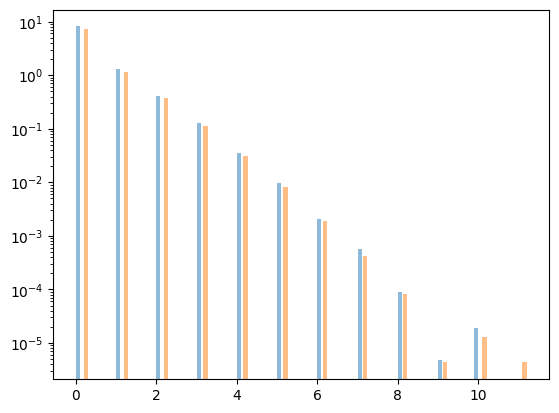

In [58]:
# model_Ntot
# base_dist_Ntot
# 203968/1817977 
cond_out = model.conv_layers(cond_tensor_jd[0])
cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# if self.sep_Ntot_cond:
cond_out_Ntot = model.cond_Ntot_layer(cond_out)

Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
Ntot_samp = np.maximum(np.round(Ntot_samp_tensor.cpu().detach().numpy()) - 1, 0).astype(int)
pl.figure()
_ = pl.hist(Ntot_samp, bins=100, density=True, alpha=0.5)
_ = pl.hist(0.2+Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
pl.yscale('log')



In [8]:
# # for jf in range(7):
# #     save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
# #     bestfit_model = (torch.load(save_bestfit_model_name))
# #     loss_min = bestfit_model['loss_min']
# #     print(loss_min)

# num_cond_Ntot = num_cond

# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss_all_it = []
# loss_min = 1e20
# epoch_tot_counter = 0
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)

# save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(0)
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# # loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']


In [9]:
print(loss)


tensor([-1.2101], device='cuda:0', requires_grad=True)


In [10]:
# print('loading bestfit model')
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']
# lr = bestfit_model['lr']
# epoch_tot_counter = bestfit_model['epoch_tot_counter']
# for g in optimizer.param_groups:
#     g['lr'] = lr

# print(loss_min, epoch_tot_counter, lr)




In [71]:
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

print(loss_min, epoch_tot_counter, stype)

train_Ntot, train_M1, train_Mdiff = 1, 0, 0
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 1, 0, 0
isim_start = 1
isim_end = 2
isim_all = np.arange(isim_start, isim_end).astype(int)
for ji in range(len(isim_all)):
    saved_all_jsim = {}
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 512
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test, _ = load_density_halo_data_NGP(
        [isim], ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
        stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, is_HR=is_HR
        )

    if cond_sim == 'fastpm':
        df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP, _ = load_density_halo_data_NGP(
            [isim], ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',
            stype=stype
            )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    # nfeatures_M1_tot = 20
    # cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):
        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            nsims=nsims_test,
            nstart=nscount,
            Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
            )
        
        if cond_sim == 'fastpm':
            return_dict_test_FP = prep_density_halo_cats(
                df_d_all_test_FP,
                df_d_all_nsh_test_FP,
                df_Mh_all_test_FP,
                df_Nh_test_FP,
                nsims=nsims_test,
                nstart=nscount,
                Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
                )    

        if cond_sim == 'fastpm':
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
        else:
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)

        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        
        if cond_sim == 'fastpm':
            mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
            # mask_tensor_Mdiff_test_FP = torch.Tensor(
            #     (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            #     ).cuda(dev)

            X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
            X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
            # X_Mdiff_test_FP = torch.Tensor(
            #     return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            #     ).cuda(dev)
            Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                            1)))).cuda(dev)
        else:
            mask_tensor_M1_test_FP = None
            mask_tensor_Mdiff_test_FP = None
            X_M1_test_FP = None
            X_Nhalo_test_FP = None
            X_Mdiff_test_FP = None
            Nhalos_truth_tensor_test_FP = None

        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            x_M1_FP=X_M1_test_FP,   
            mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    ind_less_Mmin = save_subvol_Mtot < Mmin
    ind_greater_Mmax = save_subvol_Mtot > Mmax
    save_subvol_Mtot[ind_less_Mmin] = 0.0
    save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h_subvol = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h_subvol['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h_subvol['N_halos']

    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    df_h_full = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

    bin_cents = np.array(np.arange(Nmax + 1))
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    saved_all_jsim['Nhalo_bin_cents'] = bin_cents
    saved_all_jsim['Nhalo_bin_edges'] = bin_edges

    delta_min_p, delta_max_p= -1.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
    saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all
    print(hist_samp_all)
    print(hist_truth_all)

    delta_min_p, delta_max_p= -1.0, 0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
    saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

    delta_min_p, delta_max_p= 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
    saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

    delta_min_p, delta_max_p= 2.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
    saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    bin_cents_M = np.linspace(lgMmin, lgMmax, 20)[1:-1]
    bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
    delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
    bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
    bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] - delta_b)
    saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
    saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_all[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_all[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
    saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

    delta_min_p, delta_max_p = -1.0, 0.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_low[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_low[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
    saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

    delta_min_p, delta_max_p = 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_mid[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_mid[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
    saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

    delta_min_p, delta_max_p = 2.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_high[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_high[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
    saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high

    # # import pdb; pdb.set_trace()

    # create empty arrays for Nhalos and M_halos
    Nhalos = np.zeros((ns_h, ns_h, ns_h))
    M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

                M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                
                
    
    # create empty arrays for Nhalos and M_halos
    Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

                M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                        k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')


    # sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # # load the halo data
    # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    # df_h = pk.load(open(fname, 'rb'))
    # # This has information on the halo mass for all the halos in the voxel
    # df_Mh_all_truth = df_h['M_halos']
    # df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # # This has information on the number of halos in the voxel
    # df_Nh_truth = df_h['N_halos']

    # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_full_res_' + str(ns_h) + '_z=0.pk'
    # df_h = pk.load(open(fname, 'rb'))
    # df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

    # convert to numpy arrays
    x_h_truth = np.concatenate(x_h_truth)
    y_h_truth = np.concatenate(y_h_truth)
    z_h_truth = np.concatenate(z_h_truth)
    pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    lgMass_truth = np.concatenate(lgM_truth)
    # convert to float data type
    pos_h_truth = pos_h_truth.astype('float32')
    lgMass_truth = lgMass_truth.astype('float32')

    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress

    # Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
    # Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])
    Mmin_Pk_all = np.log10(np.array([1e13, 5e13, 7e13, 1e14, 5e14]))
    Mmax_Pk_all = np.log10(np.array([1e16, 7e13, 1e14, 5e14, 1e15]))  
    Mmin_Pk_all[0] = -1.0

    saved_Pk_Bk = {}

    for j in range(len(Mmin_Pk_all)):
        saved_j = {}
        Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
        indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
        mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
        MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
        mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
        Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

        indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
        mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
        MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
        mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
        Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    

        Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

        saved_j['Pk_truth'] = Pk_truth2.Pk[:,0]
        saved_j['Pk_mock'] = Pk_mock.Pk[:,0]
        saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
        saved_j['k_Pk'] = Pk_mockxtruth2.k3D
        

    #     BoxSize = 1000.0 #Size of the density field in Mpc/h
    #     threads = 1
    #     theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
    #     saved_j['theta'] = theta

    #     k1 = 0.03
    #     k2 = 0.03
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p03  = BBk.B     #bispectrum
    #     Qk_truth_k0p03  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p03  = BBk.B     #bispectrum
    #     Qk_mock_k0p03  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p03'] = Bk_truth_k0p03
    #     saved_j['Qk_truth_k0p03'] = Qk_truth_k0p03
    #     saved_j['Bk_mock_k0p03'] = Bk_mock_k0p03
    #     saved_j['Qk_mock_k0p03'] = Qk_mock_k0p03


    #     k1 = 0.06
    #     k2 = 0.06
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p06  = BBk.B     #bispectrum
    #     Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p06  = BBk.B     #bispectrum
    #     Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
    #     saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
    #     saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
    #     saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

    #     k1 = 0.1
    #     k2 = 0.1
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p1  = BBk.B     #bispectrum
    #     Qk_truth_k0p1  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p1  = BBk.B     #bispectrum
    #     Qk_mock_k0p1  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p1'] = Bk_truth_k0p1
    #     saved_j['Qk_truth_k0p1'] = Qk_truth_k0p1
    #     saved_j['Bk_mock_k0p1'] = Bk_mock_k0p1
    #     saved_j['Qk_mock_k0p1'] = Qk_mock_k0p1


    #     k1 = 0.2
    #     k2 = 0.2
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p2  = BBk.B     #bispectrum
    #     Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p2  = BBk.B     #bispectrum
    #     Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
    #     saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
    #     saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
    #     saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


    #     k1 = 0.3
    #     k2 = 0.3
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p3  = BBk.B     #bispectrum
    #     Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p3  = BBk.B     #bispectrum
    #     Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
    #     saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
    #     saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
    #     saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

    #     # k1 = 0.4
    #     # k2 = 0.4
    #     # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_truth_k0p4  = BBk.B     #bispectrum
    #     # Qk_truth_k0p4  = BBk.Q     #reduced bispectrum
    #     # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_mock_k0p4  = BBk.B     #bispectrum
    #     # Qk_mock_k0p4  = BBk.Q     #reduced bispectrum

    #     # saved_j['Bk_truth_k0p4'] = Bk_truth_k0p4
    #     # saved_j['Qk_truth_k0p4'] = Qk_truth_k0p4
    #     # saved_j['Bk_mock_k0p4'] = Bk_mock_k0p4
    #     # saved_j['Qk_mock_k0p4'] = Qk_mock_k0p4
    
        saved_Pk_Bk[j] = saved_j

    saved_all_jsim['Pk_Bk'] = saved_Pk_Bk

    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '/'
    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '/'    
    # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '_wL2norm_highknots' + '/'    
    # # print(sdir)
    # # # make directory if doesn't exist:
    # # if not os.path.exists(sdir):
    # #     os.makedirs(sdir)
    # # import pickle as pk
    # # fname = sdir + '/summary_stats_jsim_' + str(isim) + '.pk'
    # # pk.dump(saved_all_jsim, open(fname, 'wb'))

                    








0.20969092845916748 5000 cic
DOING SIM NUMBER:1
[1730121  256321   78812   23499    6360    1616     338      75      10
       0       0       0]
[1727358  258423   79364   23661    6363    1535     355      79      10
       2       2       0]


100%|██████████| 8/8 [00:00<00:00, 34556.57it/s]



Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.09 seconds

Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.04
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing powe

In [51]:
# # model_Ntot
# # base_dist_Ntot
# # 203968/1817977 
# cond_out = model.conv_layers(cond_tensor_jd[0])
# cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# # if self.sep_Ntot_cond:
# cond_out_Ntot = model.cond_Ntot_layer(cond_out)

# Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
# pl.figure()
# _ = pl.hist(Ntot_samp_tensor.cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# _ = pl.hist(Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# pl.yscale('log')


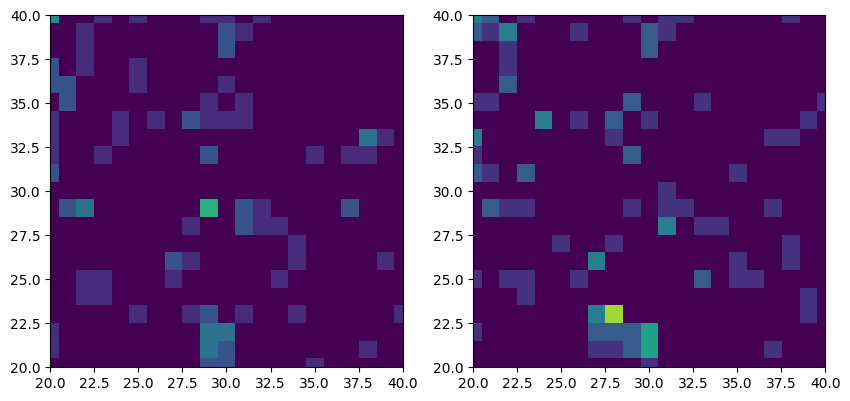

In [48]:
# pl.figure()
# pl.imshow(Nhalos[64,...])
# make it a two panel figure:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.imshow(Nhalos[64,...])
pl.xlim(20,40)
pl.ylim(20,40)

pl.subplot(122)
pl.imshow(Nhalos_truth_recomb[64,...])
pl.xlim(20,40)
pl.ylim(20,40)
pl.show()




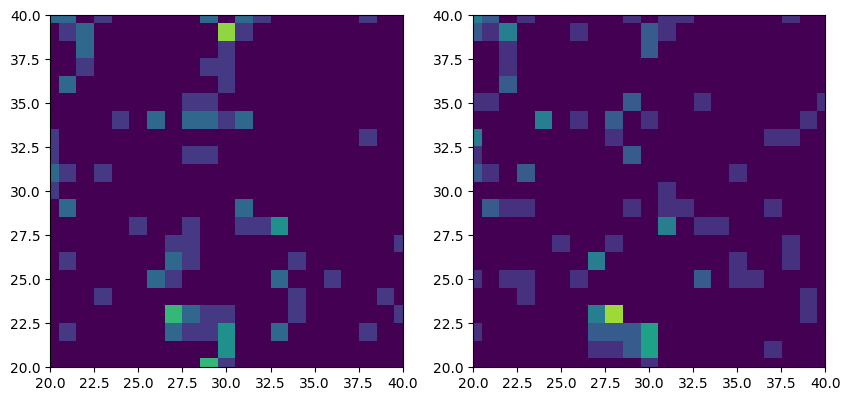

In [60]:
# pl.figure()
# pl.imshow(Nhalos[64,...])
# make it a two panel figure:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.imshow(Nhalos[64,...])
pl.xlim(20,40)
pl.ylim(20,40)

pl.subplot(122)
pl.imshow(Nhalos_truth_recomb[64,...])
pl.xlim(20,40)
pl.ylim(20,40)
pl.show()




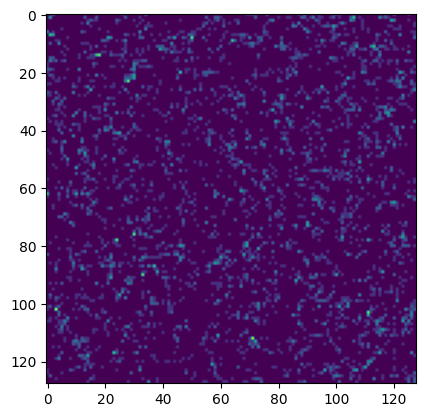

In [42]:
pl.figure()
pl.imshow(df_Nh_truth_comb[64,...])
# Nhalos.shape

In [64]:
# # Nhalos_truth_tensor_jd.shape
# if is_HR:
#     fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
# else:
#     fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
# np.sum(df_Nh_truth_comb), np.sum(Nhalos)
# np.amin(lgMass_truth[lgMass_truth > 0]), np.amin(lgMass_mock[lgMass_mock > 0])
# np.amax(lgMass_truth[lgMass_truth > 0]), np.amax(lgMass_mock[lgMass_mock > 0])

len(pos_h_mock), len(pos_h_truth)



(530036, 524062)

In [65]:
# fname
len(pos_h_truth)/len(pos_h_mock)


0.9887290674595688

In [21]:
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline




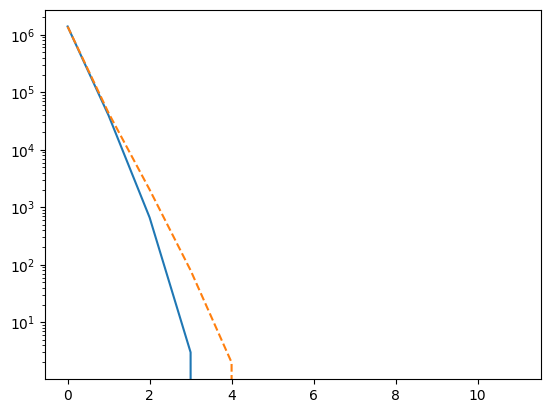

In [62]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_low_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo'], ls='--')
pl.yscale('log')




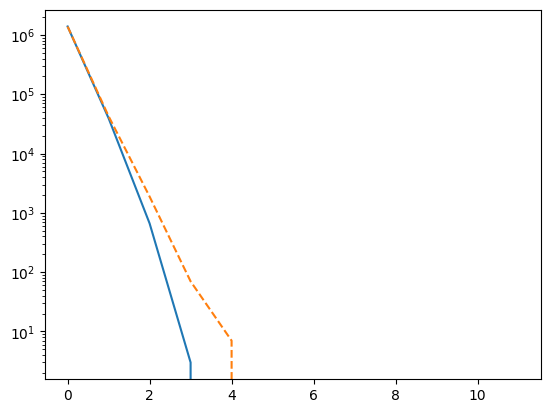

In [72]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_low_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo'], ls='--')
pl.yscale('log')




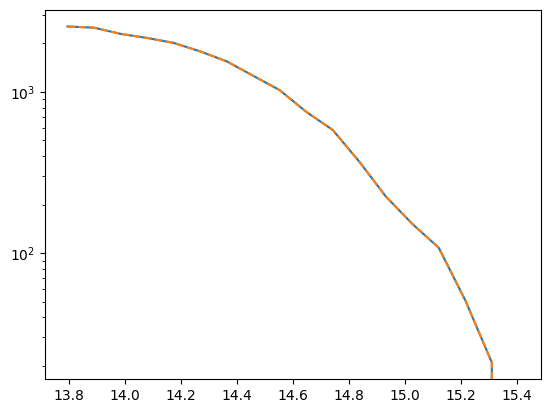

In [22]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_high_Mhalo'][0,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][0,:], ls='--')
pl.yscale('log')




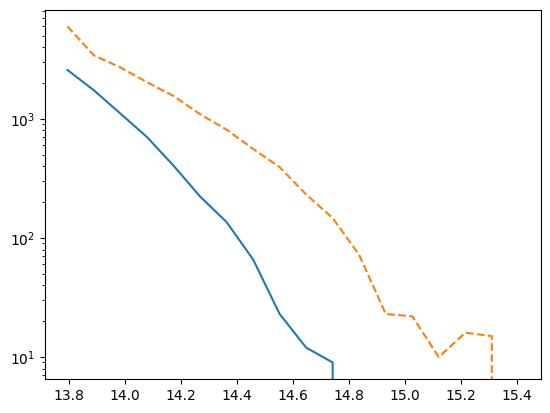

In [27]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_all_Mhalo'][1,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][1,:], ls='--')
pl.yscale('log')




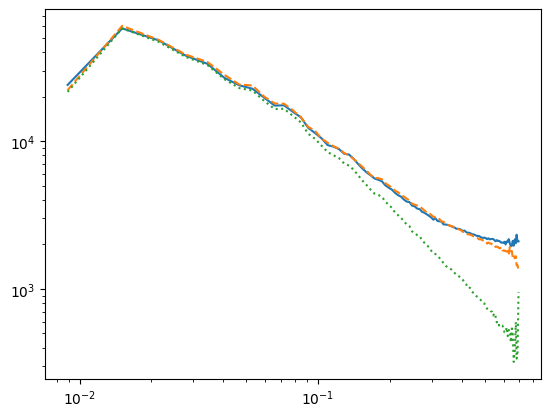

In [67]:
pl.figure()
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
pl.yscale('log')
pl.xscale('log')




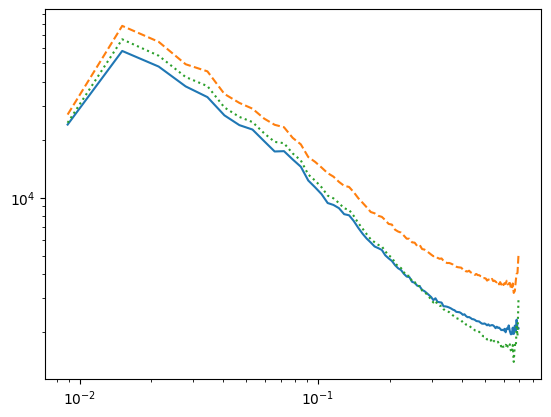

In [63]:
pl.figure()
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
pl.yscale('log')
pl.xscale('log')



In [15]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h_subvol = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h_subvol['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h_subvol['N_halos']

fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
df_h_full = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']



In [16]:
df_Mh_all_truth_comb.shape

(128, 128, 128, 4)

In [17]:
df_Mh_all_truth.shape


(512, 16, 16, 16, 4)

In [14]:
fname


'/mnt/home/spandey/ceph/Quijote/data_NGP_self/1/halos_fof_lgMmincut_5e13_full_res_128_z=0.pk'